 # Residue analysis
 Note: some sections that require a lot of computational time are commented
 and the analyses are done with precomputed results.

First, we load all necessary packages:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hcluster
import scipy.stats
import scipy.optimize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

from data_preparation import prepare_data
from data_simulation import (generate_data_mul_process)
from utilities import (unique, ctype_cols, other_ctype_cols)
from summary_plots import (mut_barplot, sample_residues, residue_umaps, channel_scatterplot)
from cluster_plots import (plot_heatmap_with_dendrogram_tri)
from ml import ml_inference_joint
from ml import ml_inference_iterative
from ml import ml_inference_cancers

warnings.filterwarnings("ignore", category=UserWarning)

 ## Loading data
 Below we load the mutational signature and their activity data from
 Alexandrov et al. 2020 paper and mutation counts derived from PCAWG samples.

In [3]:
# Processing the data
data_path = "./data/"
Path(data_path).mkdir(parents=True, exist_ok=True)
prepare_data(file_path="./alexandrov_data/", save_to_path=data_path)

# Loading the processed data
# Mutation counts from 2780 PCAWG samples
pcawg_counts = np.loadtxt(data_path + "real_pcawg_mutation_counts.txt")

# "Other" dataset from Alexandrov et al. with additional 1865 samples
other_counts = np.loadtxt(data_path + "real_other_mutation_counts.txt")

# Mutational signatures and activities for both PCAWG and "other" samples
sp_signatures = np.loadtxt(data_path + "sigProfiler_signatures.txt")  # SigProfiler set
sp_activities = np.loadtxt(data_path + "sigProfiler_activities.txt")
sa_activities = np.loadtxt(data_path + "signatureAnalyzer_activities.txt")  # SignatureAnalyzer set
sa_signatures = np.loadtxt(data_path + "signatureAnalyzer_signatures.txt")
other_sp_activities = np.loadtxt(data_path + "sigProfiler_other_activities.txt")

# Predicted mutation counts (additive model, i.e. dot product of mutational
# signature activities and the mutational signatures)
sp_pcawg_fit = np.loadtxt(data_path + "alexandrov_sigProfiler_PCAWG_fitted_counts.txt")
sa_pcawg_fit = np.loadtxt(data_path + "alexandrov_signatureAnalyzer_PCAWG_fitted_counts.txt")
sp_other_fit = np.loadtxt(data_path + "alexandrov_sigProfiler_other_fitted_counts.txt")

# PCAWG and "other" sample labels
pcawg_labels = np.loadtxt(data_path + "pcawg_labels.txt", dtype=str)
pcawg_full_labels = np.loadtxt(data_path + "pcawg_full_labels.txt", dtype=str)
other_labels = np.loadtxt(data_path + "other_labels.txt", dtype=str)
other_full_labels = np.loadtxt(data_path + "other_full_labels.txt", dtype=str)

# Signature names
signature_names = np.loadtxt(data_path + "sigProfiler_signature_names.txt", dtype=str)

 ## Residue example in a single sample
 Here we show an example residual profiles of a single colorectal cancer
 sample SP18121 from PCAWG mutational count data versus SigProfiler model fit.

In [ ]:
sample_name = "ColoRect-AdenoCA::SP18121"
i = np.where(pcawg_full_labels == sample_name)[0]
cosim = cosine_similarity(pcawg_counts[i].reshape(1, -1),
                          sp_pcawg_fit[i].reshape(1, -1))[0][0]

x = pcawg_counts[i].reshape(1, -1)
y = sp_pcawg_fit[i].reshape(1, -1)

t1 = "Total observed count: " + str(int(np.sum(x)))
t2 = "Total predicted count: " + str(int(np.sum(y)))

sample_residues(x=x, y=y, title="", text_annotations=[t1, t2, "", ""])


 ## Residue manifold approximation (UMAP)
 Here we check if there's any obvious structure in the residual profiles
 in the PCAWG samples.

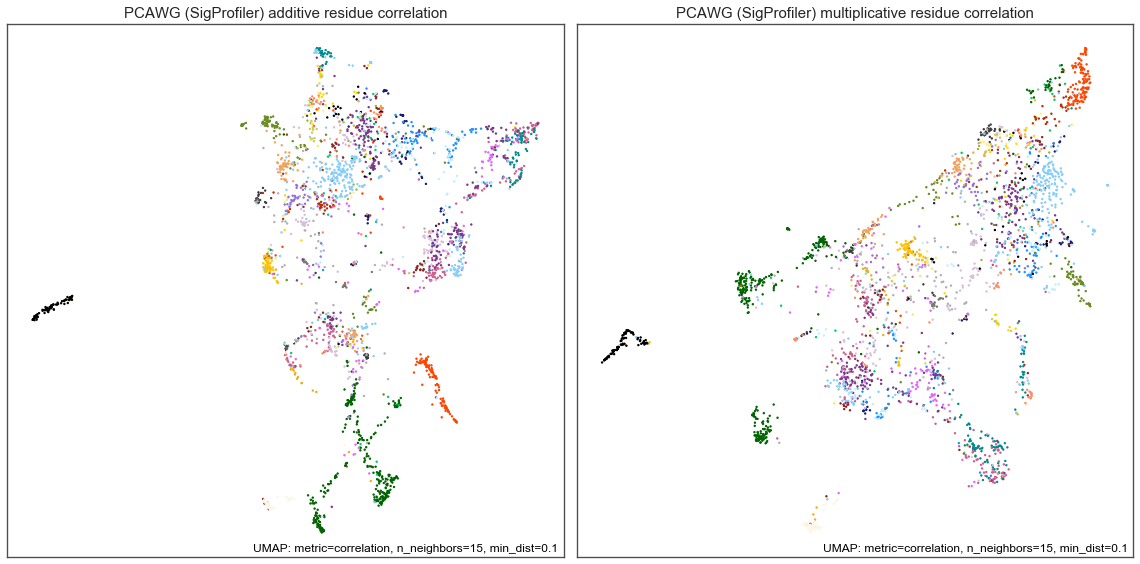

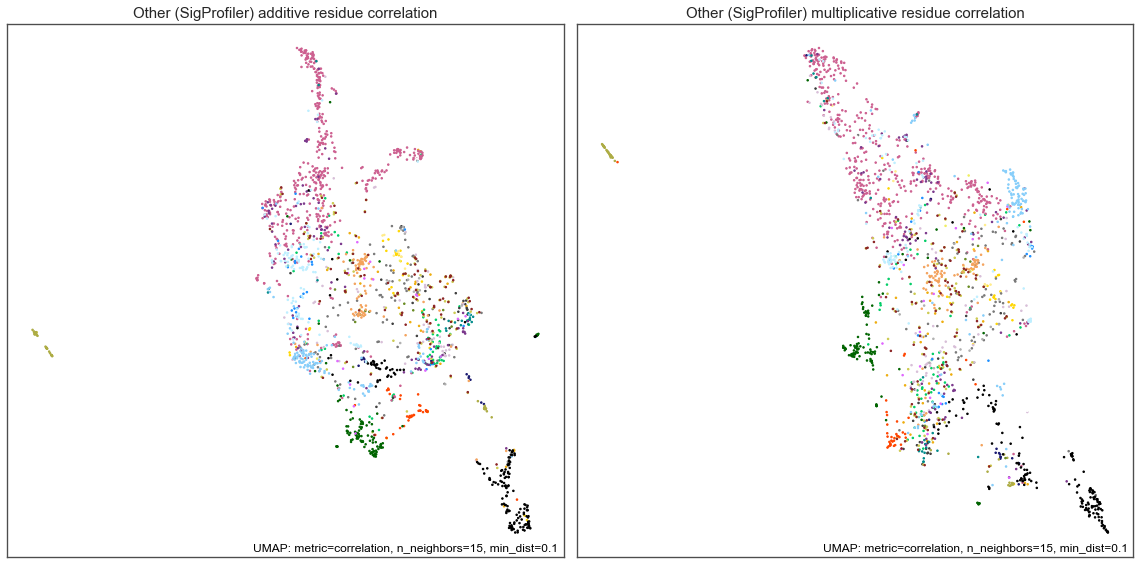

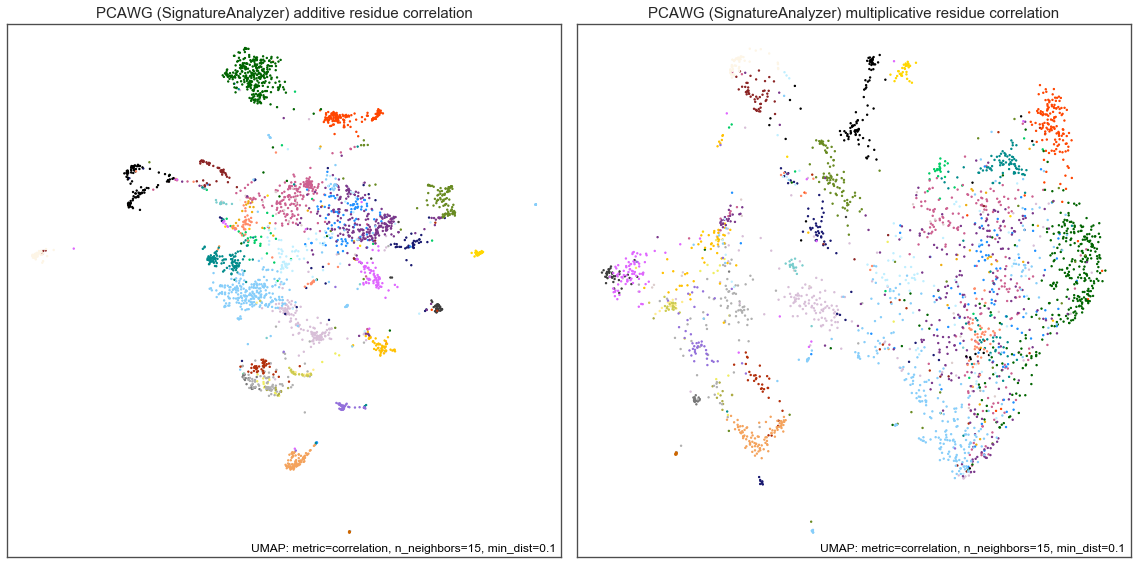

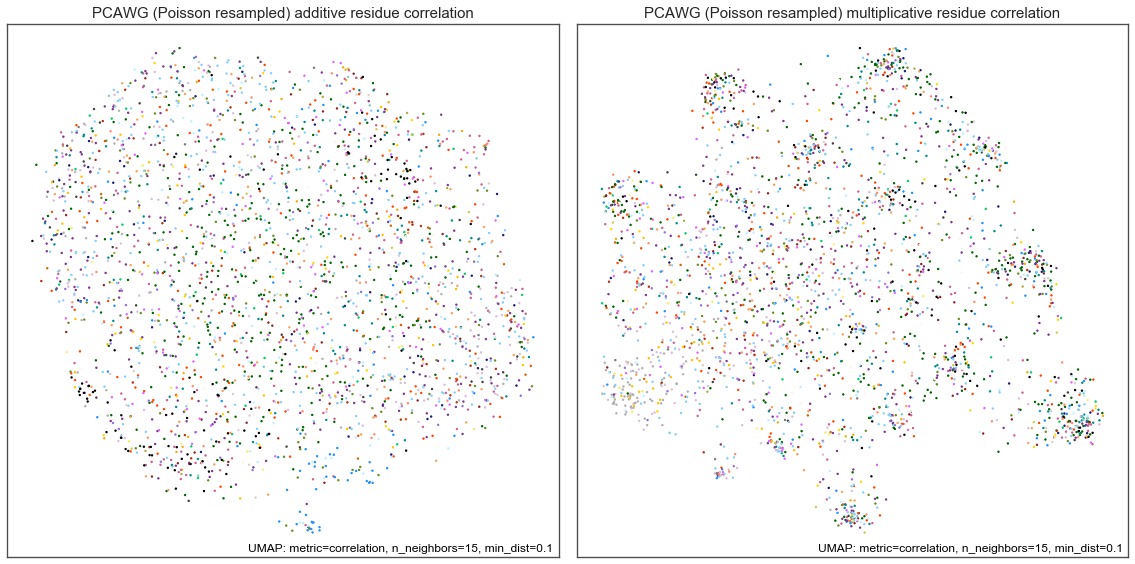

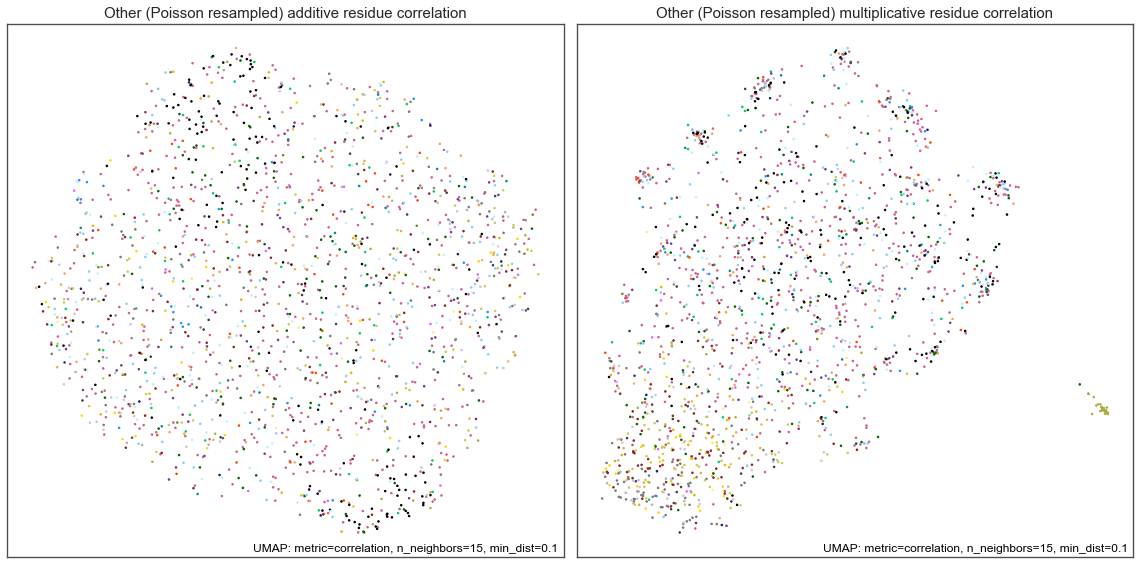

In [5]:
# PCAWG SigProfiler fits
residue_umaps(x=pcawg_counts, y=sp_pcawg_fit,
              labels=pcawg_labels, ctype_cols=ctype_cols,
              data_title="PCAWG (SigProfiler)")

# Other SigProfiler fits
residue_umaps(x=other_counts, y=sp_other_fit,
              labels=other_labels, ctype_cols=other_ctype_cols,
              data_title="Other (SigProfiler)")

# PCAWG SignatureAnalyzer fits
residue_umaps(x=pcawg_counts, y=sa_pcawg_fit,
              labels=pcawg_labels, ctype_cols=ctype_cols,
              data_title="PCAWG (SignatureAnalyzer)")

# PCAWG Poisson resampled fits
residue_umaps(x=pcawg_counts, y=scipy.stats.poisson.rvs(pcawg_counts),
              labels=pcawg_labels, ctype_cols=ctype_cols,
              data_title="PCAWG (Poisson resampled)")

# Other Poisson resampled fits
residue_umaps(x=other_counts, y=scipy.stats.poisson.rvs(other_counts),
              labels=other_labels, ctype_cols=other_ctype_cols,
              data_title="Other (Poisson resampled)")

 # Hierarchical clustering of residues
 Below is an example clustering of both multiplicative and additive residues
 of all PCAWG samples (using SigProfiler fits). The result is the two-part
 heatmap where the main clustering is done on the multiplicative residues and
 the additive residues are ordered according to the same order.
 The plots are saved to file to avoid long load times in the notebook due
 to the large plot sizes.

In [5]:
def hierarchical_clustering(x, y, labels, threshold, ctype_colors,
                            filename=None, cluster_labels=False):
    """
    Performs the hierarchical clustering on specified data and optionally
    (if filename is not None) plots the results.

    Args:
        x (matrix): Observed mutation count matrix.
        y (matrix): Predicted mutation count matrix.
        labels (array): Sample labels.
        threshold (float): Threshold for cluster formation.
        ctype_colors (dict): Dictionary assigning colors to each unique label (e.g. cancer type).
        filename (str, optional): File path to save the figure in. Defaults to None.
        cluster_labels (bool, optional): Boolean indicating whether to plot cluster labels. Defaults to False.

    Returns:
        idx (array): clustered indices.
    """

    x1 = x/(y + 1)  # PCAWG SigProfiler mul. residues
    x2 = x - y  # PCAWG SigProfiler add. residues
    Z1 = hcluster.linkage(x1, method="complete",
                          metric="correlation")  # Linkage matrix of mul. residues

    dists1 = np.corrcoef(x1)  # Correlation matrix of mul. residues
    dists2 = np.corrcoef(x2)  # Correlation matrix of add. residues

    fc = hcluster.fcluster(Z1, t=threshold,
                           criterion='distance')  # Forming clusters using threshold
    idx = fc.argsort()  # Get the cluster order

    if filename:
        totals = np.log10(np.sum(x[idx], axis=1).reshape(-1, 1))
        plot_heatmap_with_dendrogram_tri(Z=Z1, dists1=dists1, dists2=dists2,
                                         labels=labels,
                                         ctype_cols=ctype_colors,
                                         totals=totals,
                                         threshold=threshold,
                                         cluster_labels=cluster_labels,
                                         filename=filename, dpi=15,
                                         text_y=-0.15,
                                         vmin=0, vmax=1)

    return fc, idx

The below heatmaps of clustered residue correlations are automatically saved in files.

In [53]:
# PCAWG SigProfiler fit
_ = hierarchical_clustering(x=pcawg_counts, y=sp_pcawg_fit, threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_sp_tri_mul_vs_add_heatmap.pdf")

# Poisson-resampled PCAWG data "fit" (baseline)
_ = hierarchical_clustering(x=pcawg_counts, y=scipy.stats.poisson.rvs(pcawg_counts), threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_resampled_tri_mul_vs_add_heatmap.pdf")

# PCAWG SignatureAnalyzer fit
_ = hierarchical_clustering(x=pcawg_counts, y=sa_pcawg_fit, threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_sa_tri_mul_vs_add_heatmap.pdf")

# Other SigProfiler fit
_ = hierarchical_clustering(x=other_counts, y=sp_other_fit, threshold=0.75,
                            ctype_colors=other_ctype_cols,
                            labels=other_labels, cluster_labels=False,
                            filename="./other_sp_tri_mul_vs_add_heatmap.pdf")

 ## Cluster analysis
 Here we analyze several clusters from the hierarhical residue clustering
 results.

In [7]:
# Choose the data
counts = pcawg_counts
fit = sp_pcawg_fit
labels = pcawg_labels
ct_colors = ctype_cols
threshold = 0.75

# Get the clusters
fc, idx = hierarchical_clustering(x=counts, y=fit, threshold=0.75,
                                  ctype_colors=ct_colors,
                                  labels=labels)

# Choosing the cluster number. 58 here represents the large Liver-HHC cluster.
clusterno = 58
cluster_indices = np.where(fc == clusterno)[0]
cluster_labels = np.array(labels)[cluster_indices]

cluster_real = counts[cluster_indices] + 1
cluster_fit = fit[cluster_indices] + 1
print(cluster_labels)

['Biliary-AdenoCA' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-H

 Plotting summary statistics and observed vs. predicted mutation scatterplot
 of the cluster chosen above.

C>A done.
C>G done.
C>T done.
T>A done.
T>C done.
T>G done.


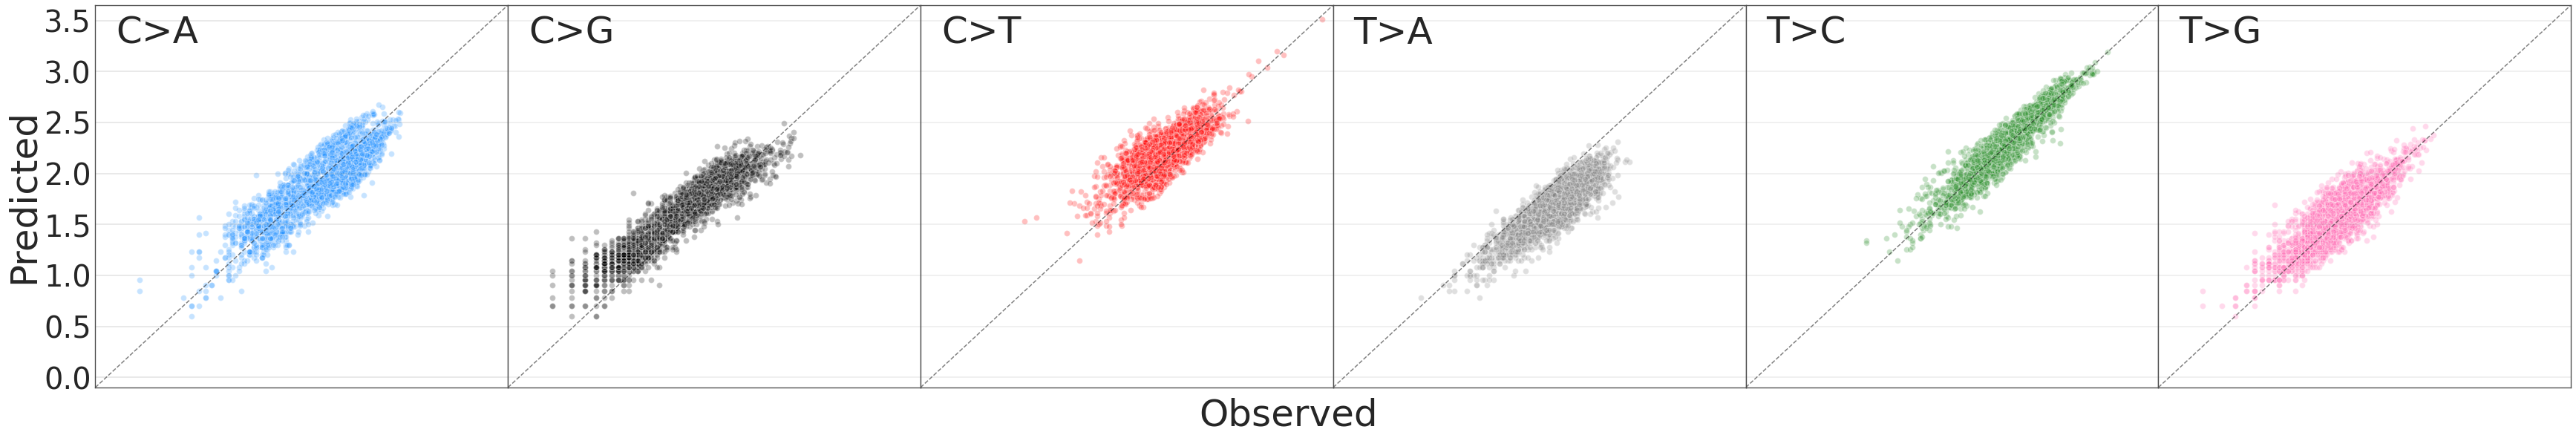

In [8]:
channel_scatterplot(obs=cluster_real, pred=cluster_fit,
                    title=None, filename=None)

 Below we display the cluster entropy histogram and some summary statistics.
 To rank the clusters, we use their entropy (from the frequencies of the sample
 labels within the cluster) and alphabet (how many unique labels within the
 cluster).

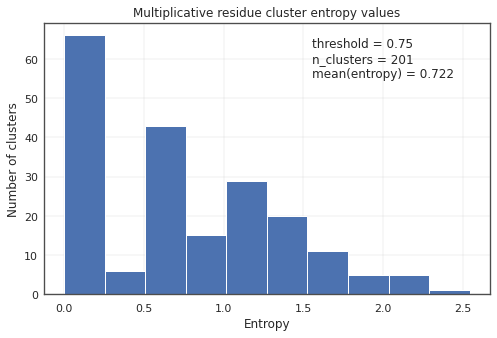

In [9]:
alphabets = np.zeros(len(np.unique(fc)))
entropies = np.zeros(len(np.unique(fc)))
label_counts = np.zeros(len(np.unique(fc)))
for i in range(len(entropies)):
    cluster_indices = np.where(fc == i+1)[0]
    cluster_labels = np.array(labels)[cluster_indices]
    entropies[i] = scipy.stats.entropy(np.unique(cluster_labels, return_counts=True)[1]/cluster_labels.shape[0])
    alphabets[i] = len(unique(cluster_labels))
    label_counts[i] = len(cluster_labels)

en_df = pd.DataFrame(data=[range(1, len(entropies) + 1), entropies, alphabets, label_counts],
                     index=["Cluster", "Entropy", "Alphabet", "Samples"]).T.set_index('Cluster')
en_df = en_df.sort_values(["Entropy", "Alphabet"])

sorted_clusters = np.array([x for _, x in sorted(zip(entropies, np.unique(fc)))])
sorted_clusters = np.array([x for _, x in sorted(zip(alphabets, np.unique(fc)))])
sorted_entropies = np.array([x for _, x in sorted(zip(alphabets, entropies))])

plt.figure(figsize=(8, 5))
hist_n, hist_bins, hist_patches = plt.hist(entropies)
plt.title("Multiplicative residue cluster entropy values")
plt.xlabel("Entropy")
plt.ylabel("Number of clusters")
plt.text(0.6, 0.8, "threshold = "
                   + str(threshold)
                   + "\nn_clusters = "
                   + str(len(entropies))
                   + "\nmean(entropy) = "
                   + str(np.round(np.mean(entropies), 3)), transform=plt.gca().transAxes)
plt.show()

 Below is the list of clusters (only those that have no less than 10 samples),
 ranked first by entropy and then by the alphabet. First 4 clusters
 (104, 111, 120 and 129) are melanoma clusters with the lowest entropy (zero).

In [10]:
print("%s\t%s\t%s\t%s" % ("Index", "Entropy", "Alphabet", "No. of samples"))
for index, row in en_df[en_df['Samples'] >= 10].iterrows():
    print("%s\t%s\t%s\t\t%s" % (int(index), np.round(row['Entropy'], 2), row['Alphabet'], row['Samples']))

Index	Entropy	Alphabet	No. of samples
104	0.0	1.0		18.0
111	0.0	1.0		17.0
120	0.0	1.0		14.0
129	0.0	1.0		10.0
152	0.0	1.0		11.0
174	0.0	1.0		10.0
58	0.14	4.0		163.0
57	0.22	2.0		17.0
144	0.31	2.0		43.0
27	0.45	2.0		12.0
6	0.59	3.0		44.0
84	0.6	3.0		11.0
170	0.61	4.0		19.0
158	0.79	4.0		17.0
80	0.82	6.0		104.0
168	0.86	3.0		11.0
151	0.87	9.0		101.0
50	0.89	4.0		17.0
46	0.9	4.0		19.0
164	0.92	3.0		30.0
67	0.92	3.0		16.0
49	0.94	3.0		20.0
145	1.01	6.0		47.0
12	1.02	5.0		27.0
5	1.08	4.0		12.0
169	1.1	6.0		24.0
10	1.11	8.0		113.0
150	1.12	5.0		36.0
77	1.13	4.0		12.0
155	1.13	5.0		19.0
149	1.16	4.0		13.0
86	1.24	4.0		11.0
105	1.27	4.0		13.0
163	1.29	6.0		13.0
64	1.32	9.0		33.0
71	1.33	6.0		25.0
78	1.36	5.0		10.0
146	1.44	5.0		14.0
172	1.47	7.0		27.0
73	1.48	8.0		23.0
85	1.48	7.0		33.0
167	1.48	6.0		19.0
11	1.49	7.0		30.0
66	1.54	6.0		22.0
54	1.55	5.0		12.0
166	1.57	9.0		39.0
153	1.58	6.0		12.0
70	1.67	13.0		92.0
74	1.71	8.0		21.0
51	1.71	9.0		36.0
76	1.72	6.0		11.0
121	1.75	7.0		10.0
60	1.78

 # Maximum likelihood inference of modulatory processes
 ## Simulated data

In [ ]:
# Data simulation with a fake modulatory process which affects two out of 6 base channels
# by reducing counts in one and increasing in the other
# Warning! May take a long time to complete. Skip to avoid execution, subsequent
# analyses can be used with precomputed results (next cell).

np.random.seed(2)
path = "./simulated_data/"
sim_r_full = np.zeros((50, 96))
sim_c_full = np.zeros((50, 100))
inf_r_full = np.zeros((50, 96))
inf_c_full = np.zeros((50, 100))
for i in range(50):
    sim_c = np.array([-2])
    sim_r = np.array([1])
    while np.min(1 + sim_c.reshape(1, -1)*sim_r.reshape(-1, 1)) < 0:
        sim_c = np.random.uniform(low=0, high=1, size=100)  # Random activities
        sim_r = np.random.normal(0, 0.05, size=96)  # Initialize with noise
        lb = np.random.choice(6, 2, replace=False)  # Choose two out of 6 SBS types
        sim_r[lb[0]*16:lb[0]*16+16] = np.random.uniform(0, 1, 16)  # Affected positively
        sim_r[lb[1]*16:lb[1]*16+16] = np.random.uniform(0, 1, 16)*(-1)  # Affected negatively
        sim_r_full[i, :] = sim_r
        sim_c_full[i, :] = sim_c
        sim_c = sim_c*np.max(np.abs(sim_r))
        sim_r = sim_r/np.max(np.abs(sim_r))  # Normalize the modulatory signature

    chosen_sigs = sp_signatures[np.random.choice(sp_signatures.shape[0], size=10)]

    generate_data_mul_process(c=sim_c, mp=sim_r, multiplier=500, N_samples=100,
                              N_signatures=chosen_sigs.shape[0], N_active_signatures=4,
                              data_path=path, filename="simulated_" + str(i),
                              signatures=chosen_sigs, manual_signatures=True)

    sim_data = np.loadtxt(path + "simulated_" + str(i) + "-samples.txt")
    sim_mu = np.loadtxt(path + "simulated_" + str(i) + "-mu.txt")
    sim_x = np.loadtxt(path + "simulated_" + str(i) + "-x.txt")
    sim_x_pre = np.loadtxt(path + "simulated_" + str(i) + "-x_pre.txt")
    sim_data_affected = np.dot(sim_x, sim_mu) + 1
    sim_labels = np.array(["Simulated_" + str(i) + "::sample" + str(j) for j in range(100)])

    # mut_barplot(sim_r, "Simulated", hline=0, ylim=(-1.1, 1.1), annotate_types=True)

    ml_inference_iterative(counts=sim_data, signatures=sim_mu, activities=sim_x,
                       full_labels=sim_labels, plot=False,
                       path=path + "simulated_inference_iterative/", nit=3)

    inf_r_full[i] = pd.read_csv(path + "simulated_inference/r_all.csv",
                                sep=",").set_index('0').loc["Simulated_" + str(i)].to_numpy()
    inf_c_full[i] = pd.read_csv(path + "simulated_inference/Simulated_" + str(i) + "_c.csv",
                    sep=",").iloc[:, 1].to_numpy()

    # mut_barplot(inf_r_full[i], "Inferred", hline=0, ylim=(-1.1, 1.1), annotate_types=True)

np.savetxt("./simulated_data/sim_r_full.txt", sim_r_full, fmt='%.10f')
np.savetxt("./simulated_data/sim_c_full.txt", sim_c_full, fmt='%.10f')
np.savetxt("./simulated_data/inf_r_full.txt", inf_r_full, fmt='%.10f')
np.savetxt("./simulated_data/inf_c_full.txt", inf_c_full, fmt='%.10f')

In [3]:
x = np.array([])
y = np.array([])
z = np.array([])
for sim_i in range(50):
    inferred_a_add = pd.read_csv("./simulated_data/simulated_inference/Simulated_" + str(sim_i) + "_it_0_a.csv").iloc[:, 1:].to_numpy().reshape(1, -1)[0]
    inferred_a_addmul = pd.read_csv("./simulated_data/simulated_inference/Simulated_" + str(sim_i) + "_it_2_a.csv").iloc[:, 1:].to_numpy().reshape(1, -1)[0]
    inferred_r = pd.read_csv("./simulated_data/simulated_inference/r_all.csv").iloc[:, 1:].to_numpy()
    inferred_r /= np.max(np.abs(inferred_r))
    inferred_c = pd.read_csv("./simulated_data/simulated_inference/Simulated_" + str(sim_i) + "_c.csv").iloc[:, 1].to_numpy()
    inferred_c /= np.max(np.abs(inferred_r))
    
    simulated_a = np.loadtxt("./simulated_data/simulated_" + str(sim_i) + "-x.txt").reshape(1, -1)[0]

    # nzi = np.where((np.log10(all_true + 1) != 0) & (np.log10(all_inf + 1) != 0))[0]
    x = np.hstack([x, inferred_a_add.reshape(1, -1)[0]])
    y = np.hstack([y, inferred_a_addmul.reshape(1, -1)[0]])
    z = np.hstack([z, simulated_a])
    
nzi = np.where((x != 0) & (y != 0))[0]
x = np.log10(x + 1)
y = np.log10(y + 1)
z = np.log10(z + 1)

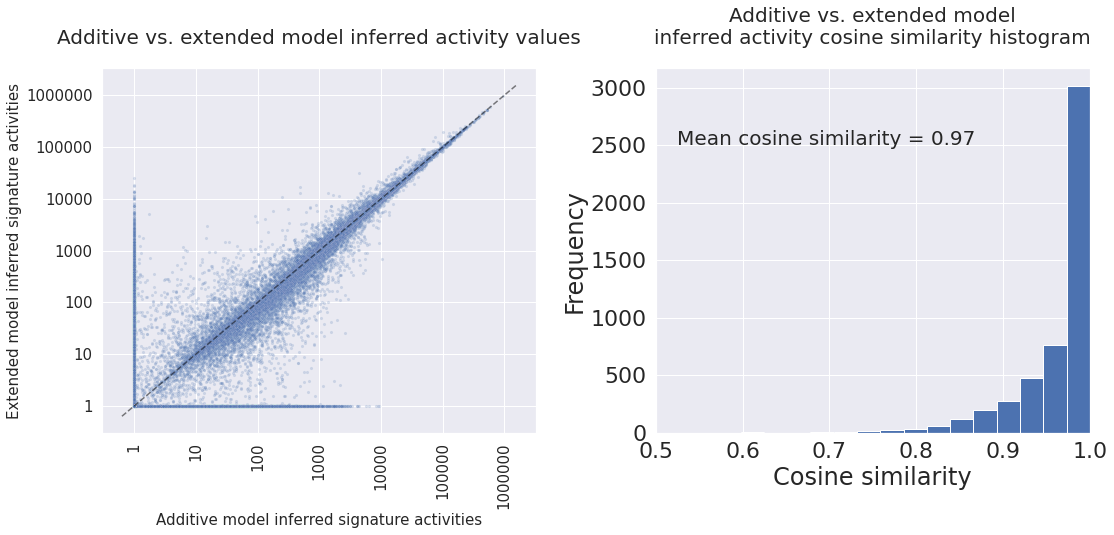

In [8]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='#1f77b4'),
                   Line2D([0], [0], color='r', lw=4, label='Gaussian density, threshold=0.25')]

sns.set(font_scale = 2)
df = pd.DataFrame({"Additive": x, "Extended": y})
# sns.jointplot(data=df, x="Additive", y="Extended", kind="kde", thresh=0.25, height=8)
# g = sns.scatterplot(data=df, x="Additive", y="Extended", height=8, kind="kde", color='r', levels=5, thresh=0.25)
plt.subplots(1, 2, figsize=(16, 8))
plt.subplot(121)
plt.plot([-0.2, 6.2], [-0.2, 6.2], linestyle='dashed', color='black', alpha=0.5)
sns.scatterplot(data=df, x="Additive", y="Extended", s=10, alpha=0.2)
# sns.kdeplot(x=x, y=y, fill=False, thresh=0.25, levels=5, color="red")
# g.plot_joint(sns.scatterplot, s=10, zorder=1)
# g.ax_joint.set_xticks(range(7))
plt.xticks(range(7), ["1", "10", "100", "1000", "10000", "100000", "1000000"], rotation=90, fontsize=15)
plt.yticks(range(7), ["1", "10", "100", "1000", "10000", "100000", "1000000"], fontsize=15)
plt.title("Additive vs. extended model inferred activity values", y=1.05, fontsize="small")
plt.xlabel("Additive model inferred signature activities", fontsize=15)
plt.ylabel("Extended model inferred signature activities", fontsize=15)
# plt.legend(handles=legend_elements, loc='upper left', fontsize=15)
# plt.show()
# g.ax_joint.legend(handles=legend_elements, loc='upper left', fontsize=15)

add_acts = x.reshape(50, 100, 10)
ext_acts = y.reshape(50, 100, 10)
cosims = np.array([])

for i in range(50):
    cosims = np.hstack([cosims, cosine_similarity(add_acts[i], ext_acts[i]).diagonal()])
    
plt.subplot(122)
plt.hist(cosims, bins=15)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Additive vs. extended model\ninferred activity cosine similarity histogram", y=1.05, fontsize="small")
plt.text(0.525, 2500, s="Mean cosine similarity = " + str(np.round(np.mean(cosims), 2)), fontsize=20)
plt.xlim(0.5, 1)
plt.tight_layout()
plt.show()

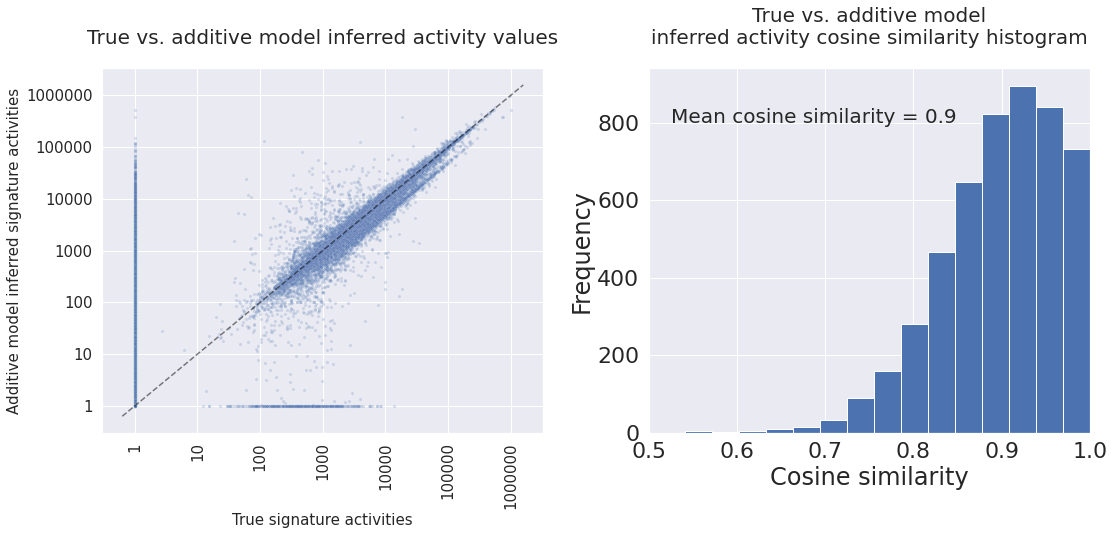

In [5]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='#1f77b4'),
                   Line2D([0], [0], color='r', lw=4, label='Gaussian density, threshold=0.25')]

sns.set(font_scale = 2)
df = pd.DataFrame({"Additive": z, "Extended": x})
# sns.jointplot(data=df, x="Additive", y="Extended", kind="kde", thresh=0.25, height=8)
# g = sns.scatterplot(data=df, x="Additive", y="Extended", height=8, kind="kde", color='r', levels=5, thresh=0.25)
plt.subplots(1, 2, figsize=(16, 8))
plt.subplot(121)
plt.plot([-0.2, 6.2], [-0.2, 6.2], linestyle='dashed', color='black', alpha=0.5)
sns.scatterplot(data=df, x="Additive", y="Extended", s=10, alpha=0.2)
# sns.kdeplot(x=x, y=y, fill=False, thresh=0.25, levels=5, color="red")
# g.plot_joint(sns.scatterplot, s=10, zorder=1)
# g.ax_joint.set_xticks(range(7))
plt.xticks(range(7), ["1", "10", "100", "1000", "10000", "100000", "1000000"], rotation=90, fontsize=15)
plt.yticks(range(7), ["1", "10", "100", "1000", "10000", "100000", "1000000"], fontsize=15)
plt.title("True vs. additive model inferred activity values", y=1.05, fontsize="small")
plt.xlabel("True signature activities", fontsize=15)
plt.ylabel("Additive model inferred signature activities", fontsize=15)
# plt.legend(handles=legend_elements, loc='upper left', fontsize=15)
# plt.show()
# g.ax_joint.legend(handles=legend_elements, loc='upper left', fontsize=15)

add_acts = z.reshape(50, 100, 10)
ext_acts = x.reshape(50, 100, 10)
cosims = np.array([])

for i in range(50):
    cosims = np.hstack([cosims, cosine_similarity(add_acts[i], ext_acts[i]).diagonal()])
    
plt.subplot(122)
plt.hist(cosims, bins=15)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("True vs. additive model\ninferred activity cosine similarity histogram", y=1.05, fontsize="small")
plt.text(0.525, 800, s="Mean cosine similarity = " + str(np.round(np.mean(cosims), 2)), fontsize=20)
plt.xlim(0.5, 1)
plt.tight_layout()
plt.show()

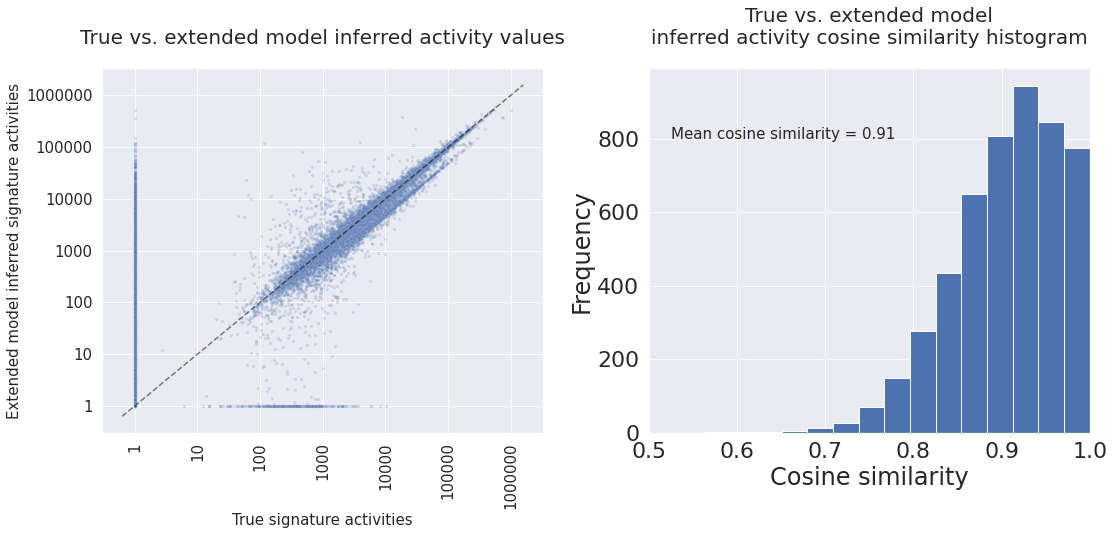

In [6]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='#1f77b4'),
                   Line2D([0], [0], color='r', lw=4, label='Gaussian density, threshold=0.25')]

sns.set(font_scale = 2)
df = pd.DataFrame({"Additive": z, "Extended": y})
# sns.jointplot(data=df, x="Additive", y="Extended", kind="kde", thresh=0.25, height=8)
# g = sns.scatterplot(data=df, x="Additive", y="Extended", height=8, kind="kde", color='r', levels=5, thresh=0.25)
plt.subplots(1, 2, figsize=(16, 8))
plt.subplot(121)
plt.plot([-0.2, 6.2], [-0.2, 6.2], linestyle='dashed', color='black', alpha=0.5)
sns.scatterplot(data=df, x="Additive", y="Extended", s=10, alpha=0.2)
# sns.kdeplot(x=x, y=y, fill=False, thresh=0.25, levels=5, color="red")
# g.plot_joint(sns.scatterplot, s=10, zorder=1)
# g.ax_joint.set_xticks(range(7))
plt.xticks(range(7), ["1", "10", "100", "1000", "10000", "100000", "1000000"], rotation=90, fontsize=15)
plt.yticks(range(7), ["1", "10", "100", "1000", "10000", "100000", "1000000"], fontsize=15)
plt.title("True vs. extended model inferred activity values", y=1.05, fontsize="small")
plt.xlabel("True signature activities", fontsize=15)
plt.ylabel("Extended model inferred signature activities", fontsize=15)
# plt.legend(handles=legend_elements, loc='upper left', fontsize=15)
# plt.show()
# g.ax_joint.legend(handles=legend_elements, loc='upper left', fontsize=15)

add_acts = z.reshape(50, 100, 10)
ext_acts = y.reshape(50, 100, 10)
cosims = np.array([])

for i in range(50):
    cosims = np.hstack([cosims, cosine_similarity(add_acts[i], ext_acts[i]).diagonal()])
    
plt.subplot(122)
plt.hist(cosims, bins=15)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("True vs. extended model\ninferred activity cosine similarity histogram", y=1.05, fontsize="small")
plt.text(0.525, 800, s="Mean cosine similarity = " + str(np.round(np.mean(cosims), 2)), fontsize=15)
plt.xlim(0.5, 1)
plt.tight_layout()
plt.show()

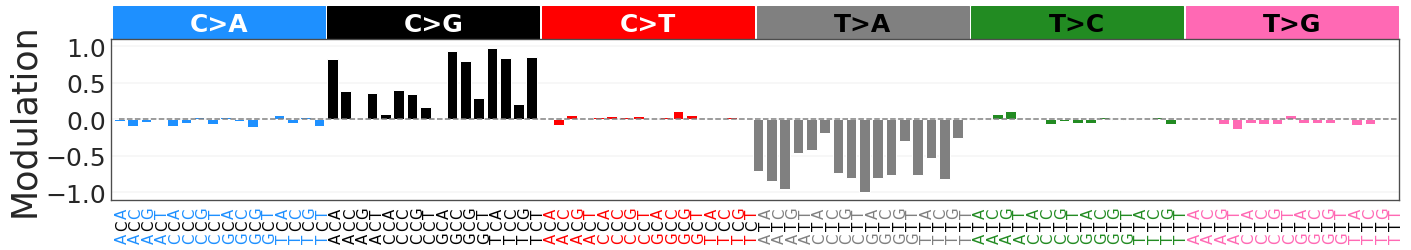

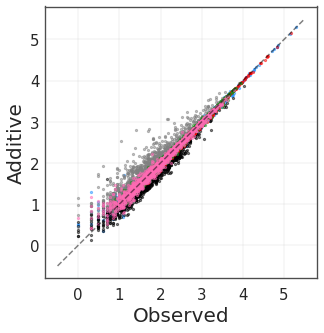

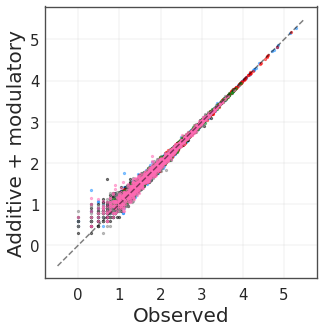

In [6]:
# We also plot the simulated versus inferred activities to see how accurate
# they are (the dataset loaded below is the same as in the manuscript results).
# Uncomment below to use precomputed results.

inf_r_full = np.loadtxt("./simulated_data/inf_r_full.txt")
inf_c_full = np.loadtxt("./simulated_data/inf_c_full.txt")
sim_r_full = np.loadtxt("./simulated_data/sim_r_full.txt")
sim_c_full = np.loadtxt("./simulated_data/sim_c_full.txt")

path = "./simulated_data/"
muts_cols = ['dodgerblue', 'black', 'red', 'grey', 'forestgreen', 'hotpink']

i = 1

mut_barplot(sim_r_full[i]/np.max(np.abs(sim_r_full[i])), "", ylim=(-1.1, 1.1), annotate_types=True, hline=0, ylabel="Modulation")
# plt.savefig("./obs_v_pred_single.png")
# plt.close()

temp_data = (np.loadtxt(path + "simulated_" + str(i) + "-samples.txt") + 1).astype(int)
temp_a = pd.read_csv(path + "simulated_inference/" + "Simulated_" + str(i) + "_a.csv").iloc[:, 1:].to_numpy()
temp_sigs = np.loadtxt(path + "simulated_" + str(i) + "-mu.txt")
temp_fit = np.dot(temp_a, temp_sigs) + 1
temp_r = inf_r_full[i]/np.max(np.abs(inf_r_full[i]))
temp_c = inf_c_full[i]*np.max(np.abs(inf_r_full[i]))
temp_corr = (temp_fit*(1 + temp_r.reshape(1, -1)*temp_c.reshape(-1, 1)) + 1).astype(int)

plt.figure(figsize=(5, 5))
plt.plot([-0.5, 5.5], [-0.5, 5.5], linestyle='dashed', color='black', alpha=0.5)
for j in range(6):
    plt.scatter(np.log10(temp_data[:, j*16:(j+1)*16]),
                np.log10(temp_fit[:, j*16:(j+1)*16]),
                c=muts_cols[j],
                s=5, alpha=0.5)
plt.axis('square')
plt.xlabel("Observed", fontsize=20)
plt.ylabel("Additive", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


plt.figure(figsize=(5, 5))
plt.plot([-0.5, 5.5], [-0.5, 5.5], linestyle='dashed', color='black', alpha=0.5)
for j in range(6):
    plt.scatter(np.log10(temp_data[:, j*16:(j+1)*16]),
                np.log10(temp_corr[:, j*16:(j+1)*16]),
                c=muts_cols[j],
                s=5, alpha=0.5)
plt.axis('square')
plt.xlabel("Observed", fontsize=20)
plt.ylabel("Additive + modulatory", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
# plt.savefig("./obs_v_corr_single.png")
# plt.close()


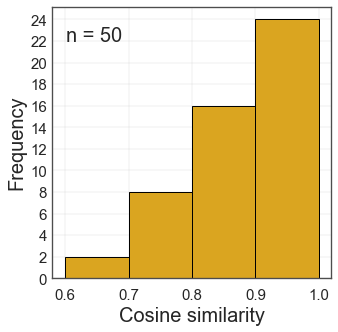

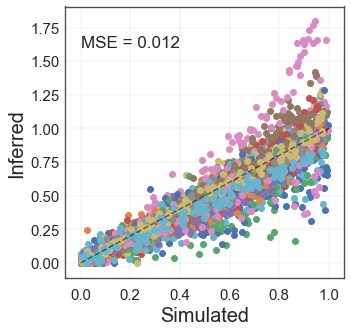

In [25]:
plt.figure(figsize=(5, 5))
n, bins, edges = plt.hist(cosine_similarity(sim_r_full/np.max(np.abs(sim_r_full)),
                                            inf_r_full/np.max(np.abs(inf_r_full))).diagonal(),
                          color="goldenrod", edgecolor="black", align="mid", bins=4)
plt.grid('axes')
ax = plt.gca()
ax.set_axisbelow(True)
plt.xlabel("Cosine similarity", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xticks(ticks=bins, labels=np.round(bins, 1), fontsize=15)
plt.yticks(ticks=range(0, 26, 2), fontsize=15)
plt.text(0.57, 22, "n = 50", fontsize=20)
plt.show()

plt.figure(figsize=(5, 5))
x = sim_c_full*np.max(np.abs(sim_r_full), axis=1).reshape(-1, 1)
y = inf_c_full*np.max(np.abs(inf_r_full), axis=1).reshape(-1, 1)
for i in range(50):
    plt.scatter(x[i], y[i])
plt.xlabel("Simulated", fontsize=20)
plt.ylabel("Inferred", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid('axes')
ax = plt.gca()
ax.set_axisbelow(True)
plt.plot([0, 1], [0, 1], linestyle='dashed', color='black', alpha=0.5)
t = str(np.round(np.mean((x - y)**2), 3))
plt.text(0, 1.6, "MSE = " + t, fontsize=17)
plt.show()

In [26]:
np.mean(cosine_similarity(sim_r_full/np.max(np.abs(sim_r_full)), inf_r_full/np.max(np.abs(inf_r_full))).diagonal())

0.8646283978974971

 ## MPs in clusters

In [6]:
counts = pcawg_counts
fit = sp_pcawg_fit
labels = pcawg_labels
ct_colors = ctype_cols
threshold = 0.75

fc, idx = hierarchical_clustering(x=counts, y=fit, threshold=0.75,
                                  ctype_colors=ct_colors,
                                  labels=labels)

# Choosing the cluster number. 58 here represents the large Liver-HCC cluster.
clusterno = 58
cluster_indices = np.where(fc == clusterno)[0]
cluster_labels = np.array(labels)[cluster_indices]

cluster_real = counts[cluster_indices]
cluster_fit = fit[cluster_indices]
print(cluster_labels)

# Dummy labels for MP inference algorithm
dummy_labels = np.array(["Cluster" + str(clusterno) + "::sample" + str(i) for i in range(len(cluster_labels))])

['Biliary-AdenoCA' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC'
 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-HCC' 'Liver-H

In [7]:
ml_inference_cancers(counts=cluster_real,
                   signatures=sp_signatures,
                   activities=sp_activities[cluster_indices],
                   full_labels=dummy_labels,
                   path="./cluster_mp_inference/", plot=True,
                   infer_activities=True)
print("Finished.")

Cluster58


  NIT   NF   F                       GTG
    0    1 -7.046615870078806E+06   6.72223095E+10
tnc: fscale = 7.28222e-07
    1    8 -7.046615870078806E+06   6.70376515E+10
    2   12 -7.085663718448890E+06   3.87767645E+10
    3   16 -7.094878763988186E+06   3.42116743E+10
    4   19 -7.104588442917909E+06   2.95163555E+10
    5   22 -7.109220398899491E+06   2.74835085E+10
    6   25 -7.126457826724324E+06   2.09888355E+10
    7   28 -7.135414899812452E+06   1.81088250E+10
    8   31 -7.144068335319022E+06   1.56296295E+10
    9   34 -7.147498950232654E+06   1.47113446E+10
   10   37 -7.149271013489467E+06   1.42490035E+10
   11   40 -7.151524399839945E+06   1.36832355E+10
   12   43 -7.159614810259464E+06   1.18135603E+10
   13   46 -7.164741649698454E+06   1.06846626E+10
   14   49 -7.168092004468943E+06   9.95887689E+09
   15   52 -7.177353532874203E+06   8.12291960E+09
   16   55 -7.180191222660965E+06   7.52012212E+09
   17   58 -7.184047233107961E+06   6.76945513E+09
   18   61 -7.1

Inferring a...
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 8]
temp_a [ 124.9654109  7307.99274173 1415.69082839 2526.12610753]
inf_a [ 124.9654109     0.         7307.99274173    0.         1415.69082839
    0.            0.            0.         2526.12610753    0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 3]
temp_a [  34.36053533 3231.18865059  242.52969324]
inf_a [  34.36053533    0.         3231.18865059  242.52969324    0.
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [10709.20919668  2382.53867887  2511.16797973]
inf_a [    0.             0.         10709.20919668     0.
  2382.53867887     0.             0.             0.
     0.          2511.16797973     0.             0.
     0.        ]
a inf: 3 Linear search failed. Retrying...
a inf: 3 Linear search failed. Retrying...
in

    3    7 -1.680026610727298E+04   1.12550386E-02
    4    9 -1.683730353202594E+04   3.49326572E-03
tnc: fscale = 1.69194e-05
    5   11 -1.683941356698427E+04   7.31429640E-05
    6   13 -1.683947893108068E+04   5.72494439E-06
tnc: fscale = 0.00041794
    7   15 -1.683948215952225E+04   9.65799300E-08
    8   17 -1.683948228702860E+04   2.18637896E-08
    9   19 -1.683948238585900E+04   2.59709795E-11
tnc: fscale = 0.196226
tnc: |fn-fn-1] = 1.44448e-08 -> convergence
   10   21 -1.683948238587344E+04   2.15206299E-13
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -2.735577502499436E+04   3.46709077E+01
tnc: fscale = 1.69831e-07
    1    4 -3.074595248042006E+04   6.86449066E+00
    2    7 -3.281064856875614E+04   1.21526977E+00
    3   10 -3.356083082909496E+04   8.19518159E-02
tnc: fscale = 3.49318e-06
    4   13 -3.365690234149239E+04   5.81800459E-03
    5   16 -3.367824767737053E+04   1.37321591E-03
    6   19 -3.367958421724351E+04   1.2

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4]
temp_a [  67.29200789 7129.70347488 2491.2672891 ]
inf_a [  67.29200789    0.         7129.70347488    0.         2491.2672891
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  60.54120903 6721.45641619 1035.54349337  458.60662174]
inf_a [  60.54120903    0.         6721.45641619    0.         1035.54349337
    0.            0.            0.            0.          458.60662174
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4]
temp_a [15157.25588737  5515.98838529]
inf_a [    0.             0.         15157.25588737     0.
  5515.98838529     0.             0.             0.
     0.             0.             0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  87.76812003 8641.54964826 1436.7

   12   26 -1.604592045812212E+04   2.47672188E-07
tnc: fscale = 0.00200938
   13   28 -1.604592063907742E+04   8.53195417E-08
   14   30 -1.604592065631932E+04   5.07675468E-10
tnc: fscale = 0.044382
   15   32 -1.604592065767119E+04   2.89387144E-09
   16   34 -1.604592065773176E+04   2.94050215E-09
   17   36 -1.604592065859270E+04   7.93343775E-12
   17   38 -1.604592065859270E+04   7.93343775E-12
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1 -1.182428361167745E+04   1.63826938E+02
tnc: fscale = 7.81281e-08
    1    4 -1.248252616276994E+04   1.99098443E+01
    2    6 -1.337959129606277E+04   1.04205851E+01
    3    8 -1.472430282159796E+04   3.20464196E+00
    4   10 -1.491988938438032E+04   2.12031274E+00
    5   12 -1.573712266392687E+04   6.13908355E-01
    6   14 -1.575327614768277E+04   6.43298036E-01
    7   16 -1.600894038750907E+04   1.61814436E-01
tnc: fscale = 2.48594e-06
    8   18 -1.602463283087638E+04   1.51889538E-02
    9   20 -1.603

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  54.76079007 5607.58133244 1176.84093175  552.78180377]
inf_a [  54.76079007    0.         5607.58133244    0.         1176.84093175
    0.            0.            0.            0.          552.78180377
    0.            0.            0.        ]
a inf: 20 Linear search failed. Retrying...
a inf: 20 Linear search failed. Retrying...
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [18447.81215761  1724.49039733  2160.33518465]
inf_a [    0.             0.         18447.81215761     0.
  1724.49039733     0.             0.             0.
     0.          2160.33518465     0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [8953.94596922 1719.9313988  1022.7264812 ]
inf_a [   0.            0.         8953.94596922    0.         1719.9313988
    0.            0.            0.            0.         1022.7264812
    0.            0.            0.   

    7   16 -2.812616439312867E+04   1.50653044E-02
    8   18 -2.816000655481507E+04   1.05402220E-03
tnc: fscale = 3.08017e-05
    9   20 -2.816310893648534E+04   1.64424679E-04
   10   22 -2.816345537469648E+04   1.24593926E-06
tnc: fscale = 0.000895884
   11   24 -2.816345788934795E+04   9.54829974E-08
   12   26 -2.816345820168297E+04   1.86162905E-12
tnc: fscale = 0.732915
tnc: |fn-fn-1] = 3.27109e-09 -> convergence
   13   28 -2.816345820168624E+04   1.76382746E-14
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.322319522022491E+04   6.16217002E+00
tnc: fscale = 4.02841e-07
    1    8 -1.416475490843223E+04   3.04419847E+00
    2   11 -1.492455022681018E+04   3.73967360E-01
    3   14 -1.518464053739093E+04   3.48984697E-02
    4   17 -1.521827593024132E+04   1.03979070E-02
tnc: fscale = 9.80679e-06
    5   20 -1.523554195548980E+04   2.60916244E-02
    6   23 -1.525117068640937E+04   6.38049185E-04
    7   26 -1.525136013109945E+04   1.

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [ 2  5 11]
temp_a [8704.32614246  445.07832529 2319.69664318]
inf_a [   0.            0.         8704.32614246    0.            0.
  445.07832529    0.            0.            0.            0.
    0.         2319.69664318    0.        ]
a inf: 40 Linear search failed. Retrying...
a inf: 40 Linear search failed. Retrying...
a inf: 40 Linear search failed. Retrying...
a inf: 40 Linear search failed. Retrying...
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 7]
temp_a [  109.74247133 10452.40529479 10322.21068215]
inf_a [  109.74247133     0.         10452.40529479     0.
     0.             0.             0.         10322.21068215
     0.             0.             0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4]
temp_a [   50.3563166  12812.82912146  4415.28501188]
inf_a [   50.3563166      0.         12812.82912146     0.
  4415.28501188     0.             0.             0.
 

9235932E-04
   10   21 -4.852310583688397E+04   1.30833997E-04
tnc: fscale = 8.74258e-05
   11   23 -4.852334400553736E+04   1.85959566E-04
   12   25 -4.852382373896123E+04   8.94770481E-05
   13   27 -4.852401875727153E+04   2.97944779E-08
tnc: fscale = 0.00579338
   14   29 -4.852401877780366E+04   3.91260390E-10
   15   31 -4.852401877915063E+04   2.05442226E-11
tnc: fscale = 0.220625
   16   33 -4.852401877922750E+04   9.25447553E-12
   17   35 -4.852401877927010E+04   9.10322564E-12
tnc: |fn-fn-1] = 6.56278e-09 -> convergence
   18   37 -4.852401877927667E+04   3.98306586E-15
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -5.931577271907313E+04   1.51791062E+03
tnc: fscale = 2.56671e-08
    1    4 -9.250401956685254E+04   2.38667728E+01
    2   10 -9.429091501273337E+04   2.26463158E+01
    3   13 -1.062872955377306E+05   4.12359552E-01
tnc: fscale = 1.55726e-06
    4   19 -1.074749992940188E+05   7.72722781E-03
    5   21 -1.0750693302369

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 6 9]
temp_a [10624.71859333  1550.50544686   964.93227617]
inf_a [    0.             0.         10624.71859333     0.
     0.             0.          1550.50544686     0.
     0.           964.93227617     0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4]
temp_a [   95.06944272 12255.66467852  2411.12234325]
inf_a [   95.06944272     0.         12255.66467852     0.
  2411.12234325     0.             0.             0.
     0.             0.             0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4]
temp_a [   59.86479953 13242.59579753  2751.46914207]
inf_a [   59.86479953     0.         13242.59579753     0.
  2751.46914207     0.             0.             0.
     0.             0.             0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [9475.18330276 3998.21919554 1387.7406112

  NIT   NF   F                       GTG
    0    1 -4.000977163253624E+04   3.08569286E+02
tnc: fscale = 5.69277e-08
    1    4 -5.367750074816027E+04   1.68770604E+01
    2    6 -5.876587894720286E+04   3.29759659E+00
    3    8 -6.146199996653693E+04   7.04879144E-01
tnc: fscale = 1.19108e-06
    4   13 -6.281367479364552E+04   1.21903934E-01
    5   15 -6.292424135450532E+04   1.04515569E-01
    6   17 -6.334664700800215E+04   8.98167803E-02
    7   19 -6.337094540119383E+04   1.31502408E-02
    8   21 -6.346763303958252E+04   8.14794859E-04
tnc: fscale = 3.50329e-05
    9   23 -6.346847269454712E+04   1.78573784E-03
   10   25 -6.346898007121205E+04   3.80289147E-04
   11   27 -6.346987130758173E+04   1.95455913E-06
tnc: fscale = 0.000715279
   12   29 -6.346987188787668E+04   2.24330739E-07
   13   31 -6.346987243639665E+04   4.48366844E-09
tnc: fscale = 0.0149342
   14   33 -6.346987246120023E+04   4.69586970E-08
   15   35 -6.346987247714502E+04   2.84438989E-08
   16   37 -6.3

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [5954.9971427  1171.67325772  569.1996962 ]
inf_a [   0.            0.         5954.9971427     0.         1171.67325772
    0.            0.            0.            0.          569.1996962
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  44.3394919  5532.50958601 1014.30652487  378.32078979]
inf_a [  44.3394919     0.         5532.50958601    0.         1014.30652487
    0.            0.            0.            0.          378.32078979
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 6]
temp_a [  19.9197671  6534.35313313  994.73536829 1510.97372662]
inf_a [  19.9197671     0.         6534.35313313    0.          994.73536829
    0.         1510.97372662    0.            0.            0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4]
temp

  NIT   NF   F                       GTG
    0    1 -1.961798351384149E+04   3.92123587E+01
tnc: fscale = 1.59694e-07
    1    4 -2.225830735540961E+04   8.04428074E+00
    2    7 -2.346254465998327E+04   3.08229395E+00
    3   10 -2.461937704202917E+04   6.05536928E-01
    4   13 -2.494992882909755E+04   3.96089877E-02
tnc: fscale = 5.02462e-06
    5   16 -2.497458073008212E+04   1.27946589E-03
    6   19 -2.497576988942411E+04   6.39453360E-06
tnc: fscale = 0.000395454
    7   22 -2.497577232581094E+04   5.78314913E-07
    8   25 -2.497577442912191E+04   2.90940602E-07
    9   28 -2.497577448088854E+04   6.33600928E-11
tnc: fscale = 0.12563
tnc: |fn-fn-1] = 8.73083e-09 -> convergence
   10   31 -2.497577448089726E+04   2.93045415E-14
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -2.903309578199699E+04   3.71922065E+01
tnc: fscale = 1.63974e-07
    1    4 -3.253312122150810E+04   7.04502744E+00
    2    7 -3.465953820606348E+04   9.98257940E-0

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 9]
temp_a [ 232.36713901 2634.07852771  845.42672554]
inf_a [ 232.36713901    0.         2634.07852771    0.            0.
    0.            0.            0.            0.          845.42672554
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 9]
temp_a [   89.23423986 10426.73425662  1752.9887985 ]
inf_a [   89.23423986     0.         10426.73425662     0.
     0.             0.             0.             0.
     0.          1752.9887985      0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 9]
temp_a [ 114.543888   6574.75023333 1047.3118068 ]
inf_a [ 114.543888      0.         6574.75023333    0.            0.
    0.            0.            0.            0.         1047.3118068
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4]
temp_a [12331.90013623  3430.69339353]
inf_a [    0. 

  F                       GTG
    0    1 -2.280667177663930E+04   3.79665267E+02
tnc: fscale = 5.13215e-08
    1    3 -2.851790436395229E+04   9.65167159E+01
    2    5 -3.415763984898041E+04   2.10436468E+01
    3    7 -3.846021214757278E+04   3.98281577E+00
    4    9 -4.096732121563198E+04   5.95306730E-01
tnc: fscale = 1.29607e-06
    5   11 -4.198948307865528E+04   8.29258959E-02
    6   14 -4.220552354677740E+04   4.24974123E-02
    7   16 -4.238734775785384E+04   1.06084710E-03
tnc: fscale = 3.07025e-05
    8   18 -4.239405559332453E+04   1.78266715E-06
tnc: fscale = 0.000748971
    9   20 -4.239406087471748E+04   1.05070517E-06
   10   22 -4.239406423487722E+04   7.02674652E-12
tnc: fscale = 0.377244
tnc: |fn-fn-1] = 1.00823e-08 -> convergence
   11   24 -4.239406423488730E+04   7.40047632E-15
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.281229390164599E+04   3.01478863E+02
tnc: fscale = 5.75932e-08
    1    4 -1.407148148509084E+04

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [8249.96724445 1344.08954587  938.66085985]
inf_a [   0.            0.         8249.96724445    0.         1344.08954587
    0.            0.            0.            0.          938.66085985
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4]
temp_a [11931.73780553  5549.12062702]
inf_a [    0.             0.         11931.73780553     0.
  5549.12062702     0.             0.             0.
     0.             0.             0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [12785.71302185  4074.74749156  1869.79204627]
inf_a [    0.             0.         12785.71302185     0.
  4074.74749156     0.             0.             0.
     0.          1869.79204627     0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [ 154.16442391 6940.18828355 1050.73698137  761.9

   15   32 -5.194363419549075E+04   7.89660612E-15
tnc: fscale = 11.2533
tnc: |fn-fn-1] = 5.1725e-11 -> convergence
   16   34 -5.194363419549080E+04   7.25522478E-15
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -2.836166194058251E+04   1.92295990E+02
tnc: fscale = 7.21132e-08
    1    3 -3.308334520312285E+04   4.76800157E+01
    2    5 -3.765628043248480E+04   9.33583617E+00
    3    7 -4.056127112003009E+04   1.37785097E+00
    4    9 -4.122297902832129E+04   1.06962114E+00
    5   11 -4.203818039524482E+04   7.54618070E-02
tnc: fscale = 3.64029e-06
    6   13 -4.212223730972438E+04   3.87688435E-03
    7   15 -4.213494599404642E+04   4.82758523E-04
    8   17 -4.213718664459683E+04   1.19408009E-04
tnc: fscale = 9.15131e-05
    9   19 -4.213734659088199E+04   6.28976694E-06
   10   21 -4.213737287512107E+04   1.02084152E-06
   11   23 -4.213737690612562E+04   1.55437641E-10
tnc: fscale = 0.0802088
   12   25 -4.213737690632568E+04   5.4760

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 6 9]
temp_a [  159.6796136  12799.37040306   912.0003852   1590.39088044]
inf_a [  159.6796136      0.         12799.37040306     0.
     0.             0.           912.0003852      0.
     0.          1590.39088044     0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  64.19472659 6409.60620855  970.0544635   935.15730439]
inf_a [  64.19472659    0.         6409.60620855    0.          970.0544635
    0.            0.            0.            0.          935.15730439
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 9]
temp_a [  49.74665878 7200.72120235  731.70325458]
inf_a [  49.74665878    0.         7200.72120235    0.            0.
    0.            0.            0.            0.          731.70325458
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [ 2 10]
temp_a [80

    8   25 -6.674919846092326E+04   8.55178263E-08
tnc: fscale = 0.00341957
    9   28 -6.674919849779080E+04   2.55739342E-10
   10   31 -6.674919850039879E+04   1.33769612E-12
tnc: fscale = 0.864612
tnc: |fn-fn-1] = 1.41377e-09 -> convergence
   11   34 -6.674919850040021E+04   2.92962575E-14
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -2.311256725055604E+04   7.96447789E+01
tnc: fscale = 1.12052e-07
    1    4 -2.647198294881028E+04   1.76929411E+01
    2    7 -2.880584459122085E+04   3.95780306E+00
    3   10 -2.993383860981588E+04   7.75364896E-01
    4   13 -3.081927571368428E+04   2.94990371E-01
    5   16 -3.130885822226755E+04   2.74259011E-02
tnc: fscale = 6.03837e-06
    6   19 -3.135106806614146E+04   6.85567198E-03
    7   22 -3.138648221968137E+04   1.59296467E-04
    8   25 -3.138671977693439E+04   1.17124111E-08
tnc: fscale = 0.0092401
    9   28 -3.138671979408004E+04   1.63215726E-09
   10   31 -3.138671980497527E+04   4.537

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  101.34905497 12279.81383923  2772.96189378   929.8154014 ]
inf_a [  101.34905497     0.         12279.81383923     0.
  2772.96189378     0.             0.             0.
     0.           929.8154014      0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [ 181.55724259 9738.47033485 1787.55756524  980.89108671]
inf_a [ 181.55724259    0.         9738.47033485    0.         1787.55756524
    0.            0.            0.            0.          980.89108671
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 9]
temp_a [10128.80994696  1813.24473733]
inf_a [    0.             0.         10128.80994696     0.
     0.             0.             0.             0.
     0.          1813.24473733     0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [9127.32607939 387

    8   21 -4.008099822518697E+04   2.50170038E-01
    9   23 -4.034301693609417E+04   9.03586932E-03
   10   25 -4.034306227795121E+04   9.83667458E-03
   11   27 -4.036754687660340E+04   1.22007198E-04
tnc: fscale = 9.05331e-05
   12   29 -4.036783863043586E+04   1.06869211E-04
   13   31 -4.036804411522409E+04   8.27333514E-06
   14   33 -4.036804623410481E+04   3.62826059E-08
tnc: fscale = 0.0052499
   15   35 -4.036804625350125E+04   2.45328329E-08
   16   37 -4.036804626462239E+04   3.22554916E-09
   17   39 -4.036804627028370E+04   2.54803049E-13
tnc: fscale = 1.98106
tnc: |fn-fn-1] = 1.24874e-10 -> convergence
   18   41 -4.036804627028383E+04   1.66495475E-13
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -4.337076010341130E+04   7.41029626E+02
tnc: fscale = 3.67352e-08
    1    4 -5.239629091548731E+04   1.75271071E+02
    2    7 -6.006492071999050E+04   3.92040825E+01
    3   10 -6.581608250269802E+04   8.09026513E+00
    4   13 -6.93

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4]
temp_a [9228.34663223 1430.00573003]
inf_a [   0.            0.         9228.34663223    0.         1430.00573003
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [8312.03099244 3014.20757224  816.5506257 ]
inf_a [   0.            0.         8312.03099244    0.         3014.20757224
    0.            0.            0.            0.          816.5506257
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 9]
temp_a [  57.7451629  5045.94118268  846.59670803]
inf_a [  57.7451629     0.         5045.94118268    0.            0.
    0.            0.            0.            0.          846.59670803
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  44.17390696 5700.42163912  994.61627546  734.870

    9   20 -4.253334249794052E+04   1.83423881E-08
tnc: fscale = 0.00738367
   10   22 -4.253334267371019E+04   3.97976913E-13
tnc: fscale = 1.58515
tnc: |fn-fn-1] = 8.07852e-10 -> convergence
   11   24 -4.253334267371100E+04   2.24144500E-16
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -3.265643216532102E+04   2.93078186E+02
tnc: fscale = 5.84128e-08
    1    3 -3.870145964772898E+04   7.28051747E+01
    2    5 -4.398834811659048E+04   1.68259682E+01
    3    7 -4.773984637691034E+04   3.14648911E+00
    4    9 -4.972384150766081E+04   4.62499896E-01
tnc: fscale = 1.47043e-06
    5   11 -5.054105238229473E+04   7.27375145E-02
    6   14 -5.064797452074102E+04   4.59234031E-02
    7   16 -5.087578119799323E+04   3.76598854E-02
    8   18 -5.092362173191682E+04   9.18469488E-03
    9   20 -5.097929924315058E+04   5.24365156E-04
tnc: fscale = 4.367e-05
   10   22 -5.098053488881805E+04   1.68463815E-04
   11   24 -5.098090462931332E+04   3.6880

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [8071.49147963 2045.23555052 1232.64253397]
inf_a [   0.            0.         8071.49147963    0.         2045.23555052
    0.            0.            0.            0.         1232.64253397
    0.            0.            0.        ]
a inf: 134 Linear search failed. Retrying...
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [10492.09821346  1724.33682006  1079.81156692]
inf_a [    0.             0.         10492.09821346     0.
  1724.33682006     0.             0.             0.
     0.          1079.81156692     0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 6]
temp_a [  97.79887136 7954.35451323  739.69387884]
inf_a [  97.79887136    0.         7954.35451323    0.            0.
    0.          739.69387884    0.            0.            0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 6]
temp_

    3    7 -5.199628548618994E+04   4.12710812E+00
    4    9 -5.272811319271086E+04   2.87813469E+00
    5   11 -5.466790071780717E+04   4.43841715E-01
tnc: fscale = 1.50102e-06
    6   13 -5.543434804692277E+04   6.65574490E-02
    7   15 -5.572191551953519E+04   1.77737545E-01
    8   17 -5.597161477011892E+04   7.05727761E-03
    9   19 -5.602885343386429E+04   2.15811472E-03
   10   21 -5.603460102413259E+04   9.62995340E-04
tnc: fscale = 3.22246e-05
   11   23 -5.603613389333336E+04   3.41490643E-05
   12   25 -5.603654294216206E+04   3.89754008E-06
   13   27 -5.603655321684523E+04   1.96380733E-07
tnc: fscale = 0.00225658
   14   29 -5.603655350621721E+04   6.55291440E-10
   15   31 -5.603655351098000E+04   4.88740730E-10
tnc: fscale = 0.0452336
   16   33 -5.603655351256326E+04   8.46694282E-11
   17   35 -5.603655351338645E+04   1.01479491E-10
   18   37 -5.603655351355880E+04   1.82181332E-15
tnc: fscale = 23.4287
   18   39 -5.603655351355879E+04   1.82181332E-15
tnc: Linea

a inf: 143 Linear search failed. Retrying...
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 4 9]
temp_a [9982.62048626 1684.33197303 1061.46937963]
inf_a [   0.            0.         9982.62048626    0.         1684.33197303
    0.            0.            0.            0.         1061.46937963
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 6]
temp_a [   93.9521209  13932.96699456  1505.1057543 ]
inf_a [   93.9521209      0.         13932.96699456     0.
     0.             0.          1505.1057543      0.
     0.             0.             0.             0.
     0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4]
temp_a [  45.53893784 8610.22647867 3057.50489968]
inf_a [  45.53893784    0.         8610.22647867    0.         3057.50489968
    0.            0.            0.            0.            0.
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 

   16   35 -5.308526734549169E+04   5.44270395E-15
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -3.784050424655400E+04   5.50921354E+02
tnc: fscale = 4.26045e-08
    1    3 -4.712888788479389E+04   1.29543270E+02
    2    5 -5.464900415236091E+04   5.08378207E+01
    3    8 -5.847216938558916E+04   1.30266814E+01
    4   10 -6.362190012395244E+04   2.47655516E+00
    5   12 -6.644095171024672E+04   4.31857021E-01
tnc: fscale = 1.5217e-06
    6   17 -6.708204084685243E+04   1.71041628E-01
    7   19 -6.732406467941018E+04   6.44479126E-02
    8   21 -6.758363721480496E+04   7.74844562E-02
    9   23 -6.760187581145461E+04   1.58845624E-02
   10   25 -6.771775497507962E+04   4.32499610E-03
   11   27 -6.771781815285988E+04   4.25618260E-03
   12   29 -6.772914521552781E+04   8.29344394E-05
tnc: fscale = 0.000109808
   13   31 -6.772975168124639E+04   6.79383686E-04
   14   33 -6.773006000648148E+04   1.02308785E-03
   15   35 -6.773045702303588E

inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 9]
temp_a [7161.85682891  797.98180362]
inf_a [   0.            0.         7161.85682891    0.            0.
    0.            0.            0.            0.          797.98180362
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 4 9]
temp_a [  73.23275835 5806.02339107 2740.34295425  673.46624072]
inf_a [  73.23275835    0.         5806.02339107    0.         2740.34295425
    0.            0.            0.            0.          673.46624072
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [0 2 9]
temp_a [ 121.46120866 4725.08917989  471.23416842]
inf_a [ 121.46120866    0.         4725.08917989    0.            0.
    0.            0.            0.            0.          471.23416842
    0.            0.            0.        ]
inf_a [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nzsi2 [2 6]
temp_a [8590.44084103  962.75172669]
inf_a [ 

 fscale = 0.000152681
    8   25 -3.687122673528735E+04   1.76331321E-07
    9   28 -3.687122729229752E+04   5.10324433E-10
tnc: fscale = 0.0442667
   10   31 -3.687122729255724E+04   9.88334464E-12
   11   34 -3.687122729262214E+04   3.70005091E-11
tnc: |fn-fn-1] = 9.03502e-09 -> convergence
   12   37 -3.687122729263118E+04   7.16573376E-14
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.100588704842028E+04   9.22051170E+01
tnc: fscale = 1.04141e-07
    1    3 -1.335786683033004E+04   2.22459599E+01
    2    5 -1.528910361379265E+04   7.69910077E+00
    3    8 -1.603159057394865E+04   1.75966918E+00
    4   10 -1.719134847044762E+04   2.14770865E-01
tnc: fscale = 2.15781e-06
    5   15 -1.736165327274586E+04   2.20494399E-01
    6   17 -1.741470884884985E+04   2.99583224E-02
    7   19 -1.748647628154513E+04   1.47649562E-04
tnc: fscale = 8.2297e-05
    8   21 -1.748658793806592E+04   2.57808328E-04
    9   23 -1.748680317137888E+04   3.6744

Plotting the inferred modulatory process...
Done.

Plotting the channel-wise scatter-plots...
C>A done.
C>G done.
C>T done.
T>A done.
T>C done.
T>G done.
Done.

Plotting the activity histogram...
Done.

Finished.


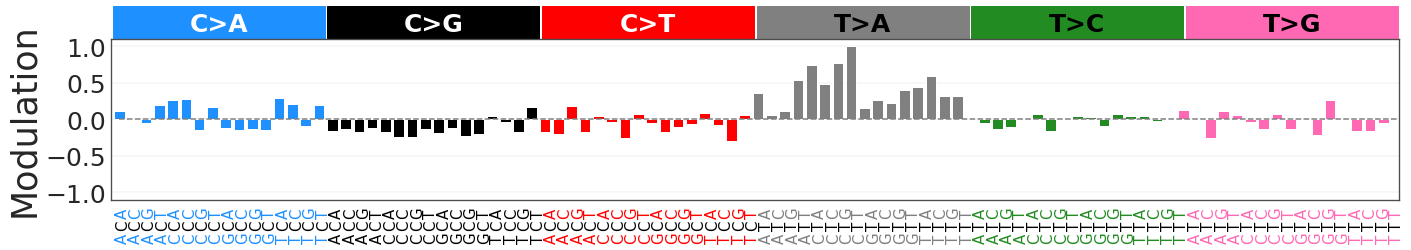

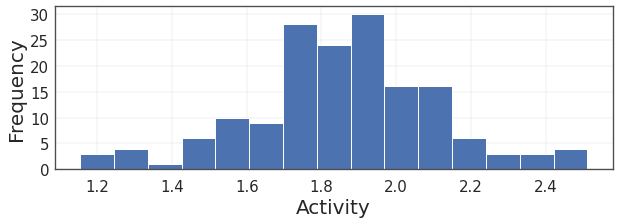

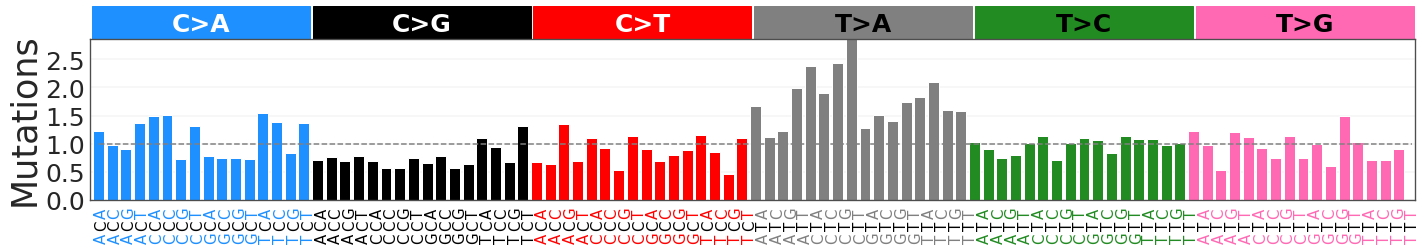

In [8]:
r = pd.read_csv("./cluster_mp_inference/r_all.csv",
                sep=",").set_index('0').loc["Cluster" + str(clusterno)].to_numpy()
c = pd.read_csv("./cluster_mp_inference/Cluster" + str(clusterno) + "_c.csv",
                sep=",").iloc[:, 1].to_numpy()*np.max(np.abs(r))
ll_df = pd.read_csv("./cluster_mp_inference/Cluster" + str(clusterno) + "_ll_change.csv", sep=",")
cluster_corrected = cluster_fit*(1 + c.reshape(-1, 1)*r.reshape(1, -1))

# Modulatory signature
mut_barplot(data=r, title="", ylabel="Modulation", hline=0, ylim=(-1.1, 1.1), annotate_types=True)

# Modulatory signature activities
plt.figure(figsize=(10, 3))
plt.hist(c, bins=15)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Activity", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Impact
mut_barplot(np.mean(1 + c.reshape(-1, 1)*r.reshape(1, -1), axis=0), "", annotate_types=True, hline=1)

 ## Cancer-type specific modulatory processes

In [4]:
# Warning! May take a long time to complete. Subsequent analyses use precomputed results.
ml_inference_cancers(counts=pcawg_counts, signatures=sp_signatures, activities=sp_activities,
                     full_labels=pcawg_full_labels, plot=False, infer_activities=True,
                     path="./cancer_mp_inference/")
print("Finished.")

NameError: name 'ml_inference_cancers' is not defined

In [9]:
# Loading data and pre-computed results of MP inference in different cancer types.
path = "./cancer_mp_inference/"
labels = pcawg_labels
counts = pcawg_counts
fit = sp_pcawg_fit
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

/run/nvme/job_12196574/tmp/ipykernel_130076/4118413192.py:57: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cax=cax)


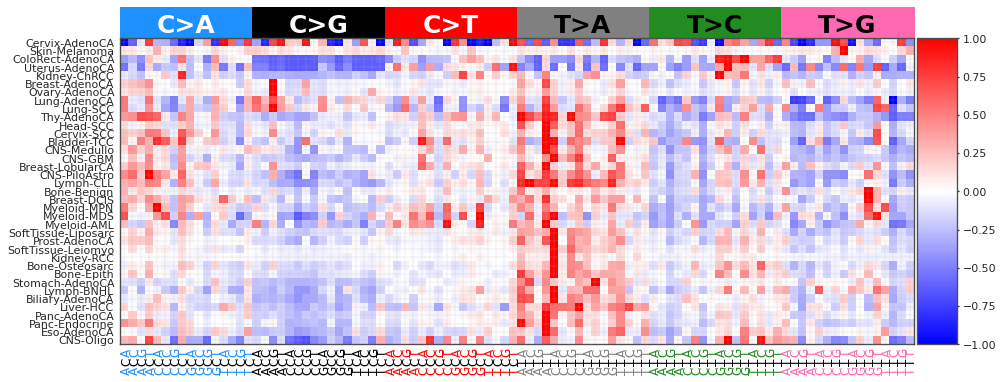

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

mut_xlabs = ['ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT',
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT',
             'ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT',
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT',
             'ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT',
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT',
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT',
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT',
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT']
mut_type_colors = (["dodgerblue"]*16 + ["black"]*16 + ["red"]*16 +
                   ["grey"]*16 + ["forestgreen"]*16 + ["hotpink"]*16)
channel6 = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
col_list = ["dodgerblue", "black", "red", "grey", "forestgreen", "hotpink"]

x = rdf.to_numpy()/np.max(np.abs(rdf.to_numpy()), axis=1).reshape(-1, 1)
Z = hcluster.linkage(x, method="complete", metric="cosine")
fc = hcluster.fcluster(Z, t=0.5, criterion='distance')
idx = fc.argsort()

plt.figure(figsize=(15, 10))
plt.imshow(x[idx], cmap="bwr")
ax = plt.gca()
text_col = ["w", "w", "w", "black", "black", "black"]
for j in range(6):
    left, width = 0 + 1/6 * j, 1/6
    bottom, height = 1.003, 0.1
    right = left + width
    top = bottom + height
    ax = plt.gca()
    p = plt.Rectangle((left, bottom), width, height, fill=True, color=col_list[j])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(0.5 * (left + right), 0.495 * (bottom + top), channel6[j],
            color=text_col[j], weight='bold', size=25,
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)
    ax.margins(x=0.002, y=0.002)

for k in range(len(mut_xlabs)):
    plt.text(k/len(mut_xlabs), -0.03, mut_xlabs[k][2],
                color=mut_type_colors[k], rotation=90, fontsize=12, transform=ax.transAxes)
    plt.text(k/len(mut_xlabs), -0.06, mut_xlabs[k][1],
                color='black', rotation=90, fontsize=12, transform=ax.transAxes)
    plt.text(k/len(mut_xlabs), -0.09, mut_xlabs[k][0],
                color=mut_type_colors[k], rotation=90, fontsize=12, transform=ax.transAxes)
plt.xticks(range(96), [""]*96, rotation=90)
plt.yticks(range(len(sorted(unique(labels)))), np.array(sorted(unique(labels)))[idx])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.show()

In [48]:
# Plotting of all MP inference results.
for ctype in sorted(unique(labels)):
    print(ctype)
    idx = np.where(labels == ctype)[0]
    r = rdf.loc[ctype].to_numpy()
    c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 1].to_numpy()
    repaired = (fit[idx]*(1 + c.reshape(-1, 1)*r.reshape(1, -1))).astype(int)
    mut_barplot(r, title=ctype+" inferred multiplicative process", ylabel="Multiplier", hline=0.0,
                filename=path + ctype + "_mp.png", ylim=(-1, 1))

    # Plotting scatterplots takes a lot of time!
    """
    channel_scatterplot(counts[idx], repaired, title=None,
                        filename=path + ctype + "_repaired_scatter.png")
    """

    fig = plt.figure(figsize=(8, 5))
    plt.hist(c, bins=20)
    plt.title(ctype + " multiplicative process activity histogram")
    plt.xlabel("Activity")
    plt.ylabel("Frequency")
    plt.savefig(path + ctype + "_activity_hist.png")
    plt.close(fig)

Biliary-AdenoCA
Bladder-TCC
Bone-Benign
Bone-Epith
Bone-Osteosarc
Breast-AdenoCA
Breast-DCIS
Breast-LobularCA
CNS-GBM
CNS-Medullo
CNS-Oligo
CNS-PiloAstro
Cervix-AdenoCA
Cervix-SCC
ColoRect-AdenoCA
Eso-AdenoCA
Head-SCC
Kidney-ChRCC
Kidney-RCC
Liver-HCC
Lung-AdenoCA
Lung-SCC
Lymph-BNHL
Lymph-CLL
Myeloid-AML
Myeloid-MDS
Myeloid-MPN
Ovary-AdenoCA
Panc-AdenoCA
Panc-Endocrine
Prost-AdenoCA
Skin-Melanoma
SoftTissue-Leiomyo
SoftTissue-Liposarc
Stomach-AdenoCA
Thy-AdenoCA
Uterus-AdenoCA


In [11]:
# Gathering of data for LL-gain plots
labels = pcawg_labels
counts = pcawg_counts
activities = sp_activities
signatures = sp_signatures
fit = np.dot(activities, signatures)
path = "./cancer_mp_inference/"
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

# For equal spacing in LL-gain plot
# (326 is the largest number of cancer samples of one type, i.e. Liver-HCC)
max_samples = 326
# max_samples = 484
ll_diffs = np.zeros((len(unique(labels)), max_samples))
ll_means = np.zeros(len(unique(labels)))
c_activities = np.zeros((len(unique(labels)), max_samples))

sum_means = np.zeros(len(unique(labels)))
sums = np.zeros((len(unique(labels)), max_samples))
totals = np.zeros((len(unique(labels)), max_samples))
add_muts = np.zeros((len(unique(labels)), max_samples))

rem_muts = np.zeros((len(unique(labels)), max_samples))
mean_impact = np.zeros((len(unique(labels)), 96))
i = 0
for ctype in sorted(unique(labels)):
    print(i, ctype)
    ctype_ll = pd.read_csv(path + ctype + "_ll_change.csv", sep=",")
    ctype_r = rdf.loc[ctype].to_numpy()
    ctype_c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 1].to_numpy()
    ctype_idx = np.where(labels == ctype)[0]
    ctype_counts = counts[ctype_idx]
    ctype_fit = fit[ctype_idx]
    ctype_rep = (ctype_fit*(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1))).astype(int)

    temp_sums = np.full(max_samples, np.nan)
    temp_totals = np.full(max_samples, np.nan)
    temp_activities = np.full(max_samples, np.nan)

    temp_mut_add = np.full(max_samples, np.nan)
    temp_mut_rem = np.full(max_samples, np.nan)
    mut_diff = ctype_rep - ctype_fit

    sample_mut_added = np.zeros(len(mut_diff))
    sample_mut_removed = np.zeros(len(mut_diff))

    for k in range(len(mut_diff)):
        sample = mut_diff[k]
        sample_mut_added[k] = np.sum(sample[sample > 0])
        sample_mut_removed[k] = np.sum(sample[sample < 0])

    boundary = int((max_samples - len(ctype_ll))/2)

    temp_activities[boundary:boundary + len(ctype_ll)] = ctype_c
    c_activities[i] = temp_activities

    temp_mut_add[boundary:boundary + len(ctype_ll)] = sample_mut_added
    temp_mut_rem[boundary:boundary + len(ctype_ll)] = sample_mut_removed
    add_muts[i] = temp_mut_add
    rem_muts[i] = temp_mut_rem

    mean_impact[i] = np.mean(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1), axis=0)

    temp_sums[boundary:boundary + len(ctype_ll)] = np.sum(np.abs(mut_diff), axis=1)
    temp_totals[boundary:boundary + len(ctype_ll)] = np.sum(ctype_counts, axis=1)
    ll_diff = np.abs(ctype_ll["After"].abs() - ctype_ll["Before"].abs())
    temp = np.full(max_samples, np.nan)
    temp[boundary:boundary + len(ctype_ll)] = ll_diff
    ll_diffs[i] = temp
    ll_means[i] = np.mean(np.log10(ll_diff + 1))
    sum_means[i] = np.mean(np.sum(np.abs(mut_diff), axis=1))
    sums[i] = temp_sums
    totals[i] = temp_totals
    i += 1

0 Biliary-AdenoCA
1 Bladder-TCC
2 Bone-Benign
3 Bone-Epith
4 Bone-Osteosarc
5 Breast-AdenoCA
6 Breast-DCIS
7 Breast-LobularCA
8 CNS-GBM
9 CNS-Medullo
10 CNS-Oligo
11 CNS-PiloAstro
12 Cervix-AdenoCA
13 Cervix-SCC
14 ColoRect-AdenoCA
15 Eso-AdenoCA
16 Head-SCC
17 Kidney-ChRCC
18 Kidney-RCC
19 Liver-HCC
20 Lung-AdenoCA
21 Lung-SCC
22 Lymph-BNHL
23 Lymph-CLL
24 Myeloid-AML
25 Myeloid-MDS
26 Myeloid-MPN
27 Ovary-AdenoCA
28 Panc-AdenoCA
29 Panc-Endocrine
30 Prost-AdenoCA
31 Skin-Melanoma
32 SoftTissue-Leiomyo
33 SoftTissue-Liposarc
34 Stomach-AdenoCA
35 Thy-AdenoCA
36 Uterus-AdenoCA


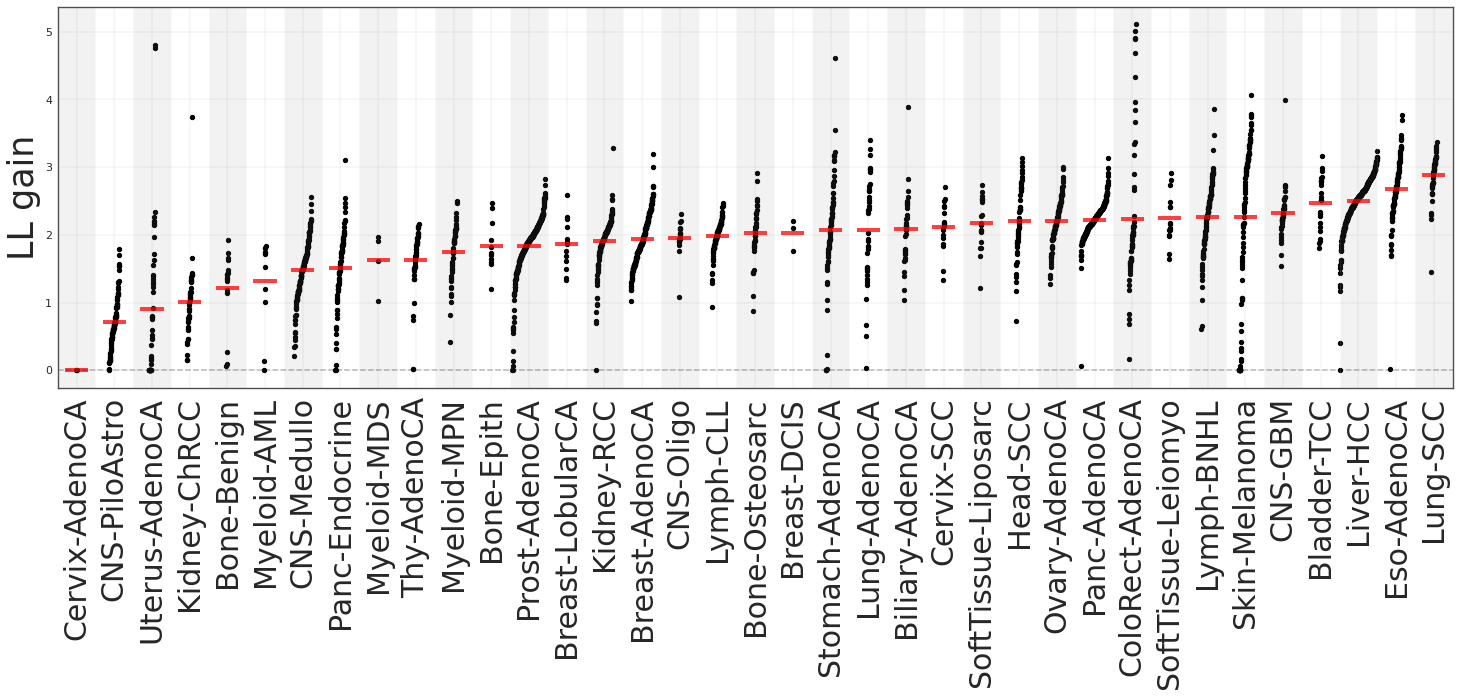

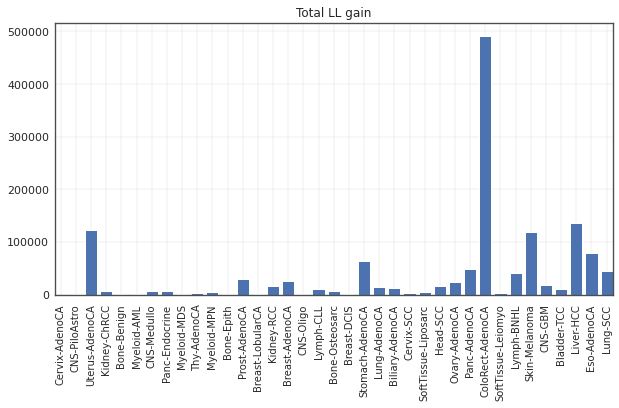

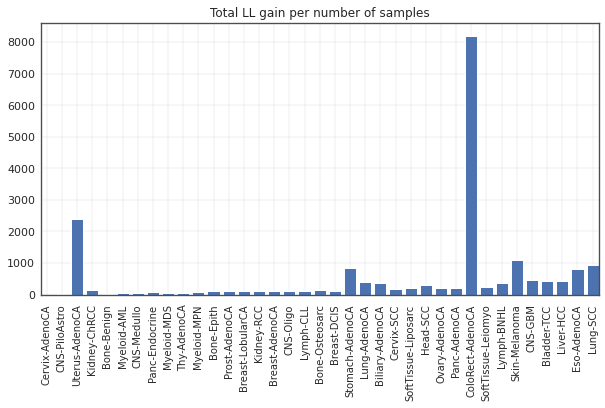

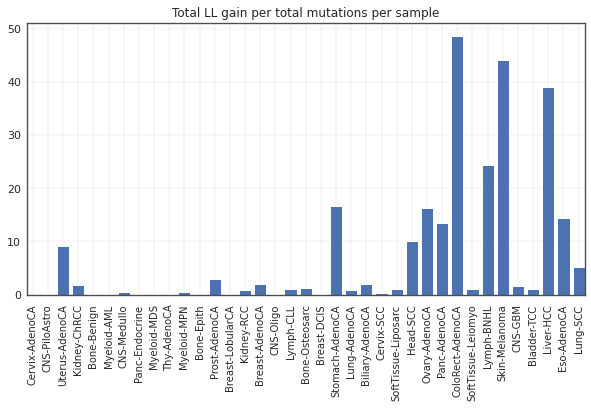

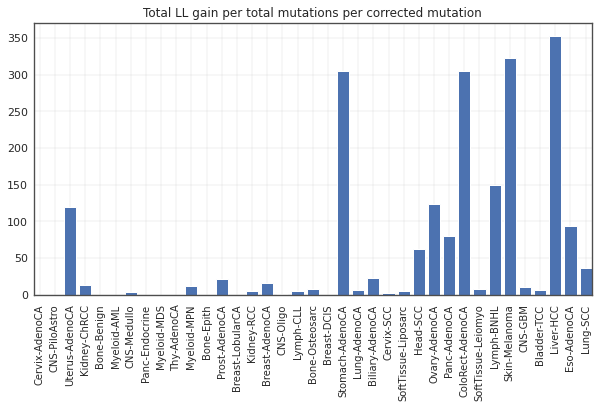

In [12]:
# Plotting the log-likelihood gain per cancer type per sample
plt.figure(figsize=(25, 7))
idx = np.array(range(len(unique(labels))))
idx = np.array([x for _, x in sorted(zip(ll_means, idx))])
prev = 0
c = 0
ll_gain_per_sample = []
total_ll_gain = []
ll_gain_per_corrected = []
ll_gain_per_total = []
for i in idx:
    y = sorted(np.log10(np.abs(ll_diffs[i]) + 1))
    temp = ll_diffs[i][~np.isnan(ll_diffs[i])]
    ll_gain_per_sample.append(int(np.sum(np.abs(temp))/len(temp)))
    ll_gain_per_corrected.append(int(np.sum(np.abs(temp))/(np.abs(add_muts[~np.isnan(add_muts)][i]) +
                                 np.abs(rem_muts[~np.isnan(rem_muts)][i]))))
    total_ll_gain.append(int(np.sum(np.abs(temp))))
    ll_gain_per_total.append(np.sum(temp/totals[~np.isnan(totals)][i]))
    plt.scatter(range(prev, prev + max_samples), y, marker=".", c="black", s=75)
    if c % 2 == 0:
        plt.axvspan(prev, prev + max_samples, facecolor='grey', alpha=0.1)
    plt.hlines(ll_means[i],
               prev + int(max_samples/2) - 100, prev + int(max_samples/2) + 100,
               color="red", alpha=0.75, linewidth=4)
    prev += max_samples
    c += 1

plt.xticks(range(int(max_samples/2), max_samples*len(unique(labels)), max_samples),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=30)
# plt.gca().set_yticklabels()
# plt.yticks(ticks=1 + plt.yticks()[0], labels=[str(10**x) for x in range(int(plt.ylim()[1]) + 1)], fontsize=25)

plt.hlines(0, 0, max_samples*len(unique(labels)), color="black", linestyle="--", alpha=0.25)
plt.ylabel("LL gain", fontsize=35)
# plt.title("Per-sample log-likelihood gain", fontsize=30)
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(labels)))), total_ll_gain)
plt.xticks(range(len(sorted(unique(labels)))),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain")
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type (normalized by number of samples)
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(labels)))), ll_gain_per_sample)
plt.xticks(range(len(sorted(unique(labels)))),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain per number of samples")
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type (normalized by total mutations)
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(labels)))), ll_gain_per_total)
plt.xticks(range(len(sorted(unique(labels)))),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain per total mutations per sample")
plt.margins(x=0)
plt.show()

# Total log-likelihood gain per cancer type (normalized by the number of corrected mutations)
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted(unique(labels)))), ll_gain_per_corrected)
plt.xticks(range(len(sorted(unique(labels)))),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=10)
plt.title("Total LL gain per total mutations per corrected mutation")
plt.margins(x=0)
plt.show()

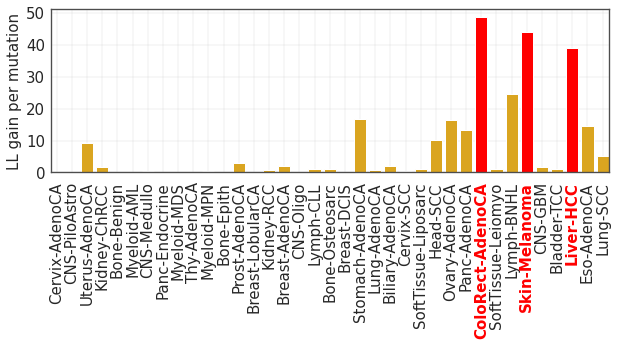

In [13]:
plt.figure(figsize=(10, 3))
bars = plt.bar(range(len(sorted(unique(labels)))), ll_gain_per_total, color="goldenrod")
plt.xticks(range(len(sorted(unique(labels)))),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=15)
# plt.title("Total LL gain per total mutations per sample")
bars[28].set_facecolor("red")
bars[31].set_facecolor("red")
bars[34].set_facecolor("red")
plt.margins(x=0)
plt.grid('axes')
ax = plt.gca()
ax.set_axisbelow(True)
ax.get_xticklabels()[28].set_color("red")
ax.get_xticklabels()[31].set_color("red")
ax.get_xticklabels()[34].set_color("red")
ax.get_xticklabels()[28].set_fontweight("bold")
ax.get_xticklabels()[31].set_fontweight("bold")
ax.get_xticklabels()[34].set_fontweight("bold")
plt.ylabel("LL gain per mutation", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
path = "./cancer_mp_inference/"
labels = pcawg_labels
full_labels = pcawg_full_labels
counts = pcawg_counts
activities = sp_activities
signatures = sp_signatures
fit = sp_pcawg_fit
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

ll_gains = []
real_counts = np.array([]).reshape(0, 96)
fit_counts = np.array([]).reshape(0, 96)
corrected_counts = np.array([]).reshape(0, 96)
mean_impacts = np.array([]).reshape(0, 96)
sig_attr = np.array([]).reshape(0, activities.shape[1])
sig_corr_attr = np.array([]).reshape(0, activities.shape[1])
i = 0
for ctype in sorted(unique(labels)):
    print(i, ctype)
    ctype_ll = pd.read_csv(path + ctype + "_ll_change.csv", sep=",")
    ll_gains.append(np.abs(ctype_ll["After"].abs() - ctype_ll["Before"].abs()).to_numpy())
    ctype_r = rdf.loc[ctype].to_numpy()
    ctype_c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 1].to_numpy()
    ctype_idx = np.where(labels == ctype)[0]
    ctype_counts = counts[ctype_idx]
    ctype_fit = fit[ctype_idx]
    ctype_rep = (ctype_fit*(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1))).astype(int)
    impact = np.mean(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1), axis=0)
    mean_impacts = np.vstack([mean_impacts, impact])

    ctype_count_df = pd.DataFrame(data=ctype_counts)
    ctype_count_df["Sample"] = full_labels[ctype_idx]
    ctype_count_df = ctype_count_df.set_index("Sample")
    ctype_count_df.to_csv(path + ctype + "_real_counts.csv", sep=",")
    real_counts = np.vstack([real_counts, ctype_count_df.to_numpy()])

    ctype_fit_df = pd.DataFrame(data=ctype_fit)
    ctype_fit_df["Sample"] = full_labels[ctype_idx]
    ctype_fit_df = ctype_fit_df.set_index("Sample")
    ctype_fit_df.to_csv(path + ctype + "_fit_counts.csv", sep=",")
    fit_counts = np.vstack([fit_counts, ctype_fit_df.to_numpy()])
    fit_residue_sums = np.sum(np.abs(ctype_count_df.to_numpy() - ctype_fit_df.to_numpy()), axis=1)
    fit_mul_residue_sums = np.mean(ctype_count_df.to_numpy()/(ctype_fit_df.to_numpy() + 1), axis=1)
    fit_res_kl = scipy.stats.entropy(ctype_count_df.to_numpy() + 1, ctype_fit_df.to_numpy() + 1, axis=1)

    ctype_rep_df = pd.DataFrame(data=ctype_rep)
    ctype_rep_df["Sample"] = full_labels[ctype_idx]
    ctype_rep_df = ctype_rep_df.set_index("Sample")
    ctype_rep_df.to_csv(path + ctype + "_corrected_counts.csv", sep=",")
    corrected_counts = np.vstack([corrected_counts, ctype_rep_df.to_numpy()])
    corrected_residue_sums = np.sum(np.abs(ctype_count_df.to_numpy() - ctype_rep_df.to_numpy()), axis=1)
    corrected_mul_residue_sums = np.mean(ctype_count_df.to_numpy()/(ctype_rep_df.to_numpy() + 1), axis=1)
    corrected_res_kl = scipy.stats.entropy(ctype_count_df.to_numpy() + 1, ctype_rep_df.to_numpy() + 1, axis=1)

    idx = np.where(labels == ctype)[0]
    resi_attr = activities[idx]/np.sum(activities[idx], axis=1).reshape(-1, 1)
    corr_attr = resi_attr*np.sum(ctype_rep_df.to_numpy(), axis=1).reshape(-1, 1)
    sig_attr = np.vstack([sig_attr, np.sum(activities[idx], axis=0)])
    sig_corr_attr = np.vstack([sig_corr_attr, np.sum(corr_attr, axis=0)])

    plt.figure(figsize=(5, 5))
    plt.boxplot([np.log10(np.sum(ctype_count_df.to_numpy(), axis=1) + 1),
                 np.log10(fit_residue_sums + 1),
                 np.log10(corrected_residue_sums + 1)], vert=False)
    plt.title(ctype)
    plt.yticks(range(1, 4), ["Total\nmutations", "Additive\nresidues", "Corrected\nresidues"], fontsize=12)
    plt.xlabel("Mutations (log10)")
    plt.tight_layout()
    # plt.savefig(path + "impacts/" + ctype + "_muts")
    plt.close()

    # mut_barplot(mean_impacts[i], "", "Impact", hline=1, ylim=(0, np.max(mean_impacts[i] + 0.1)), annotate_types=True,
    #             filename=path + "impacts/" + ctype + "_impact")

    normsums = np.sum(ctype_count_df.to_numpy(), axis=1)
    b1 = scipy.stats.entropy(scipy.stats.poisson.rvs(ctype_count_df.to_numpy()) + 1, ctype_count_df.to_numpy() + 1,
                             axis=1)
    b2 = fit_res_kl
    b3 = corrected_res_kl

    line_props = dict(alpha=0.25)
    bbox_props = dict(alpha=0.25)

    plt.figure(figsize=(10, 5))
    strip_data = pd.DataFrame(data={'Model': ['Baseline']*len(idx) + ['Alexandrov']*len(idx) + ['Ours']*len(idx),
                                    'Value': np.array([b1] + [b2] + [b3]).reshape(1, -1)[0],
                                    'Mutations': np.array([normsums]*3).reshape(1, -1)[0]})
    plot = sns.stripplot(x='Model', y='Value', hue='Mutations', data=strip_data,
                         palette='ocean', jitter=True, alpha=0.75)
    plt.boxplot([b1,
                 b2,
                 b3], widths=(0.5, 0.5, 0.5), positions=range(3),
                whiskerprops=line_props, boxprops=bbox_props, showfliers=False)
    plt.xticks(range(3), ["Baseline", "Original", "Modulated"], fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Model", fontsize=20)
    plt.ylabel("KL divergence", fontsize=20)
    plot.get_legend().set_visible(False)
    sns.despine()

    normalize = mcolors.Normalize(vmin=strip_data['Mutations'].min(), vmax=strip_data['Mutations'].max())
    colormap = cm.ocean

    for n in strip_data['Mutations']:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(strip_data['Mutations'])
    cbar = plt.colorbar(scalarmappaple)
    cbar.set_label("Mutations", fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    # plt.title("Normalized total additive residue")
    # plt.savefig(path + "impacts/" + ctype + "_strip_sums")
    plt.close()

    i += 1

ll_gains = np.concatenate(ll_gains)

0 Biliary-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


1 Bladder-TCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


2 Bone-Benign


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)
/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


3 Bone-Epith
4 Bone-Osteosarc


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


5 Breast-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)
/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


6 Breast-DCIS
7 Breast-LobularCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


8 CNS-GBM


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


9 CNS-Medullo


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


10 CNS-Oligo


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


11 CNS-PiloAstro


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)
/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


12 Cervix-AdenoCA
13 Cervix-SCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


14 ColoRect-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


15 Eso-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


16 Head-SCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


17 Kidney-ChRCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


18 Kidney-RCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


19 Liver-HCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


20 Lung-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


21 Lung-SCC


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


22 Lymph-BNHL


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


23 Lymph-CLL


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)
/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


24 Myeloid-AML
25 Myeloid-MDS


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


26 Myeloid-MPN


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


27 Ovary-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


28 Panc-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


29 Panc-Endocrine


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


30 Prost-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


31 Skin-Melanoma


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


32 SoftTissue-Leiomyo


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


33 SoftTissue-Liposarc


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


34 Stomach-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


35 Thy-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


36 Uterus-AdenoCA


/run/nvme/job_12196574/tmp/ipykernel_130076/2788847630.py:109: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalarmappaple)


In [8]:
# Heatmap of corrected residues
_ = hierarchical_clustering(x=real_counts, y=corrected_counts, threshold=0.75,
                            ctype_colors=ctype_cols,
                            labels=pcawg_labels, cluster_labels=False,
                            filename="./pcawg_sp_corrected_tri_mul_vs_add_heatmap.pdf")

 ## Prediction of LL-gain and the number of corrected mutations

In [4]:
activities = sp_activities
labels = pcawg_labels
total_counts = np.sum(activities, axis=1).reshape(-1, 1)
corrected_muts = np.sum(np.abs(real_counts - corrected_counts), axis=1).reshape(-1, 1)
model_comp_data = [[activities, ll_gains, labels],
                   [np.log10(activities + 1), np.log10(ll_gains + 1), labels],
                   [activities/total_counts, np.concatenate(ll_gains.reshape(-1, 1)/total_counts), labels],
                   [activities, corrected_muts, labels],
                   [np.log10(activities + 1), np.log10(corrected_muts + 1), labels],
                   [activities/total_counts, np.concatenate(corrected_muts.reshape(-1, 1)/total_counts), labels]]

rf = RandomForestRegressor()
group_cv = StratifiedKFold(n_splits=5, shuffle=True)
num_cvs = 10
results = []

for n in range(len(model_comp_data)):
    x = model_comp_data[n][0]
    y = model_comp_data[n][1]
    z = model_comp_data[n][2]
    foldscores = np.zeros((num_cvs, 5))

    for i in range(num_cvs):
        j = 0
        signature_importances = np.zeros(x.shape[1])
        scores = []

        for train_i, test_i in group_cv.split(x, z):
            train_x, test_x = x[train_i], x[test_i]
            train_y, test_y = y[train_i], y[test_i]
            rf.fit(train_x, train_y)
            fimp = rf.feature_importances_
            signature_importances += fimp
            pred_y = rf.predict(test_x)
            score = rf.score(test_x, test_y)
            scores.append(score)
            foldscores[i, j] = score
            xmax = np.max([np.max(test_y), np.max(pred_y)])
            j += 1

        print(str(np.mean(scores)))
        signature_importances /= 5
    results.append(foldscores)

for i in range(len(results)):
    results[i] = np.concatenate(results[i])

0.9100888934694777
0.8488236476925991
0.878529008155452
0.8153096013219109
0.8549673095646005
0.8623025237976739
0.757363833146826
0.8902191273845059
0.8740671461120144
0.922936035932738
0.6866713458560673
0.7026529701420655
0.6905017260262224
0.6978864050095254
0.7006110556721794
0.6890794547416799
0.698666042070588
0.7020310919328411
0.6934625871870055
0.6947640708219067
0.3237164797841805
0.32167083249252404
0.30954438280972163
0.3118255679542311
0.30489762057268
0.30604416073608076
0.30142867962062087
0.3030764090084532
0.2867338197986328
0.31508113770891916
0.7518721447007641
0.7175883552995377
0.7546291669481298
0.7280412663132141
0.7056960857899611
0.7766273739917613
0.7863462963199895
0.7695244795212679
0.8056968749227232
0.7881375548167925
0.9373096963875571
0.9323755506775517
0.9342344471380241
0.9340035541850755
0.934402216018217
0.9357510380105383
0.9351624773904819
0.9336270358609072
0.9344486150645966
0.93555605872222
0.2370079739706333
0.24447661949790245
0.2560854395269

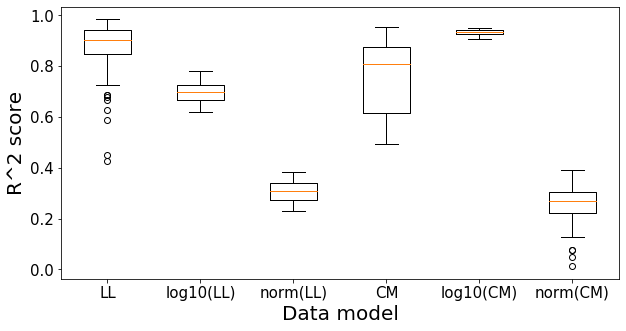

In [5]:
# Plotting the CV results
plt.figure(figsize=(10, 5))
plt.boxplot([results[0], results[1], results[2], results[3], results[4], results[5]])
plt.xlabel("Data model", fontsize=20)
plt.ylabel("R^2 score", fontsize=20)
plt.xticks(range(1, 7), ["LL", "log10(LL)", "norm(LL)", "CM", "log10(CM)", "norm(CM)"], fontsize=15)
plt.yticks(fontsize=15)
plt.show()

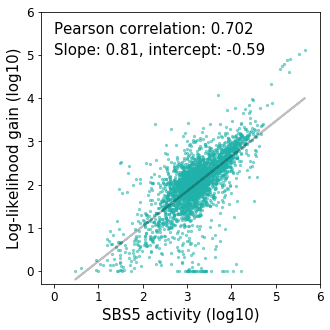

In [6]:
# Relationship between SBS5 and log-likelihood gain
sigind = np.where(signature_names == "SBS5")[0]
idx = np.where(sp_activities[:, sigind] != 0)[0]
x = np.log10(sp_activities[idx, sigind] + 1)
y = np.log10(ll_gains[idx] + 1)
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(5, 5))
plt.plot(x, m*x + b, color="black", linestyle="-", linewidth=2, alpha=0.25)
plt.scatter(x, y, alpha=0.5, s=5, c="lightseagreen")
plt.xlabel("SBS5 activity (log10)", fontsize=15)
plt.ylabel("Log-likelihood gain (log10)", fontsize=15)
plt.text(x=0, y=5, fontsize=15, s="Slope: " + str(np.round(m, 2)) + ", intercept: " + str(np.round(b, 2)))
plt.text(x=0, y=5.5, s="Pearson correlation: " + str(np.round(np.corrcoef(x, y)[0, 1], 3)), fontsize=15)
plt.xlim(-0.3, 6)
plt.ylim(-0.3, 6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

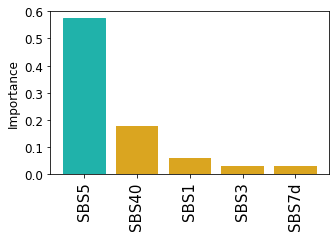

In [7]:
# Top 5 most important signatures in best model
rf = RandomForestRegressor()
rf.fit(model_comp_data[4][0], model_comp_data[4][1])  # Best result, log10(CM)
fimp = rf.feature_importances_

sorted_pairs = sorted(zip(fimp, signature_names))
fimp_sorted, signature_names_sorted = [list(tuple) for tuple in zip(*sorted_pairs)]

plt.figure(figsize=(5, 3))
barlist = plt.bar(range(5), fimp_sorted[::-1][:5], color="goldenrod")
barlist[0].set_color('lightseagreen')
plt.xticks(range(5), signature_names_sorted[::-1][:5], rotation=90, fontsize=15)
plt.ylabel("Importance", fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.6)
plt.show()

In [8]:
# Each signature mutation load contribution to Liver cancer samples
canc = "Liver-HCC"
tot_cg = 0
tot_ta = 0
for i in range(len(signature_names)):
    sig_ind = np.where(signature_names == signature_names[i])[0]
    sample_ind = np.where(pcawg_labels == canc)[0]
    sig = sp_signatures[sig_ind][0]
    total_act = np.sum(sp_activities[sample_ind, sig_ind])
    print(signature_names[i])
    cg = int(np.sum((sig*total_act)[16:32]))
    ta = int(np.sum((sig*total_act)[48:64]))
    tot_cg += cg
    tot_ta += ta
    print(cg)
    print(ta)
    print()

print(tot_cg)
print(tot_ta)

SBS1
194
421

SBS2
0
0

SBS3
0
0

SBS4
18060
40420

SBS5
255811
211946

SBS6
43
89

SBS7a
0
0

SBS7b
0
0

SBS7c
0
0

SBS7d
0
0

SBS8
0
0

SBS9
68
191

SBS10a
0
0

SBS10b
0
0

SBS11
0
0

SBS12
8150
26369

SBS13
0
0

SBS14
8
114

SBS15
0
0

SBS16
4201
5529

SBS17a
10
153

SBS17b
14
85

SBS18
69
106

SBS19
651
174

SBS20
0
0

SBS21
0
0

SBS22
801
51198

SBS23
0
0

SBS24
208
153

SBS25
0
0

SBS26
135
316

SBS27
0
0

SBS28
1
17

SBS29
6887
4607

SBS30
21
16

SBS31
140
439

SBS32
0
0

SBS33
0
0

SBS34
0
0

SBS35
4320
9864

SBS36
0
0

SBS37
0
0

SBS38
0
0

SBS39
0
0

SBS40
29044
22542

SBS41
0
0

SBS42
0
0

SBS43
0
0

SBS44
0
0

SBS45
0
0

SBS46
0
0

SBS47
0
0

SBS48
0
0

SBS49
0
0

SBS50
0
0

SBS51
0
0

SBS52
0
0

SBS53
30
14

SBS54
29
29

SBS55
0
0

SBS56
3
46

SBS57
0
0

SBS58
0
0

SBS59
0
0

SBS60
0
0

328898
374838


In [9]:
# Toal observed mutations in C>G and T>A channels in liver cancers
sample_ind = np.where(pcawg_labels == canc)[0]
samp = pcawg_counts[sample_ind]
print("C>G observed:", int(np.sum(samp[:, 16:32])))
print("T>A observed:", int(np.sum(samp[:, 48:64])))

# Total predicted
samp = sp_pcawg_fit[sample_ind]
print("C>G predicted:", int(np.sum(samp[:, 16:32])))
print("T>A predicted:", int(np.sum(samp[:, 48:64])))

C>G observed: 265479
T>A observed: 552976
C>G predicted: 326298
T>A predicted: 372253


# Additional analyses, May revisions

In [16]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msi_samples = pd.read_csv("PCAWG_MSI_samples.txt").to_numpy().reshape(1, -1)[0]

In [17]:
cancers = sorted(unique(pcawg_labels))
sbss = ["SBS6", "SBS14", "SBS15", "SBS20", "SBS21", "SBS26", "SBS44"]

In [18]:
thresh = 30000
htmb_a = sp_activities[np.where(np.sum(sp_activities, axis=1) >= thresh)[0]]
htmb_sigs = []
for sample in htmb_a:
    htmb_sigs.append(signature_names[np.where(sample == np.max(sample))[0]])
htmb_sigs = np.array(np.unique(htmb_sigs))
no_htmb_sigs = [x for x in signature_names if x not in htmb_sigs]
htmb_samples = np.where(np.sum(sp_activities, axis=1) >= thresh)[0]
nonhtmb_samples = np.where(np.sum(sp_activities, axis=1) < thresh)[0]

In [19]:
mmr_sbs = ["SBS6", "SBS14", "SBS15", "SBS20", "SBS21", "SBS26", "SBS44"]
tmb_sbs = ["SBS2", "SBS3", "SBS6", "SBS9", "SBS10b", "SBS10a", "SBS13", "SBS14", "SBS15", "SBS21", "SBS26", "SBS44"]

all_lldf = pd.DataFrame(columns=["Sample", "Before", "After"])
all_cdf = pd.DataFrame(columns=["Sample", "Activity"])
cancer_lengths = []
cancer_labels = []
for cancer in cancers:
    cdf = pd.read_csv("./cancer_mp_inference/" + cancer + "_c.csv")
    samples = cdf.iloc[:, 0].to_numpy()
    cdf.columns = ["Sample", "Activity"]
    cancer_lengths.append(len(samples))
    cancer_labels.append(samples[0].split("::")[0])
    lldf = pd.read_csv("./cancer_mp_inference/" + cancer + "_ll_change.csv").drop("Unnamed: 0", axis=1)
    lldf["Sample"] = samples
    all_lldf = pd.concat([all_lldf, lldf])
    all_cdf = pd.concat([all_cdf, cdf])
    # ll = (lldf["Before"] - lldf["After"]).to_numpy()
all_samples = all_lldf["Sample"]

indices = []
for label in all_samples:
    indices.append(np.where(pcawg_full_labels == label)[0])
indices = np.array(indices).reshape(1, -1)[0]

all_ll_change = (all_lldf["Before"] - all_lldf["After"]).to_numpy().astype(float)
# all_ll_change = np.log10(all_ll_change + 1)
# all_ll_change /= np.sum(pcawg_counts[indices], axis=1)
all_cdf = all_cdf.reset_index().iloc[:, 1:]
all_lldf = all_lldf.reset_index().iloc[:, 1:]
# all_lldf["Mutations"] = np.sum(pcawg_counts, axis=1)

sig_idx = []
for sig in htmb_sigs:
    sig_idx.append(np.where(signature_names == sig)[0][0])
    

non_sig_idx = []
for sig in no_htmb_sigs:
    non_sig_idx.append(np.where(signature_names == sig)[0][0])

all_lldf["nonHTMB_Mutations"] = np.sum(sp_activities[:, non_sig_idx], axis=1)
all_lldf["HTMB_Mutations"] = np.sum(sp_activities[:, sig_idx], axis=1)
all_lldf["Mutations"] = np.sum(sp_activities, axis=1)

R^2: 0.5473477049060566
MSI R^2: 0.44494282043514
HTMB R^2: 0.26013327904025796


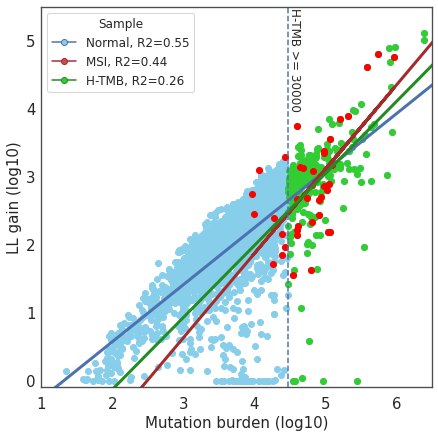

In [20]:
from sklearn.linear_model import LinearRegression

x = np.log10(all_lldf["Mutations"].to_numpy() + 1)
y = np.log10(np.abs(all_lldf["Before"] - all_lldf["After"]).to_numpy().astype(float) + 1)

# x /= np.sum(x)
# y /= np.sum(y)

model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
r_sq1 = model.score(x.reshape(-1, 1), y.reshape(-1, 1))
print(f"R^2: {r_sq1}")

plt.figure(figsize=(7, 7))
# plt.plot([-0.5, 6.5], [-0.5, 6.5], linestyle='dashed', color='black', alpha=0.5)
plt.scatter(x, y, color="skyblue")

htmb_idx = np.where(all_lldf["Mutations"].to_numpy() >= thresh)[0]
htmb_x = x[htmb_idx]
htmb_y = y[htmb_idx]
plt.scatter(htmb_x, htmb_y, color="limegreen")

msi_x = []
msi_y = []
for i in range(len(msi_samples)):
    msi_idx = np.where(pcawg_full_labels == msi_samples[i])[0]
    if len(msi_idx) > 0:
        msi_x.append(x[msi_idx])
        msi_y.append(y[msi_idx])
        plt.scatter(x[msi_idx], y[msi_idx], color="red", label="MSI")

msi_x = np.array(msi_x).reshape(1, -1)[0]
msi_y = np.array(msi_y).reshape(1, -1)[0]

model2 = LinearRegression()
model2.fit(msi_x.reshape(-1, 1), msi_y.reshape(-1, 1))
r_sq2 = model2.score(msi_x.reshape(-1, 1), msi_y.reshape(-1, 1))
print(f"MSI R^2: {r_sq2}")

# msi_x /= np.sum(msi_x)
# msi_y /= np.sum(msi_y)



# y_pr = model.predict(x.reshape(-1, 1))
# y_pr2 = model2.predict(msi_x.reshape(-1, 1))
# y_pr2 = model2.predict(np.arange(0, 7, 7/39).reshape(-1, 1))

x1 = list(x)
y1 = list(y)
p1 = np.polyfit(x, y, 1)

xlims = plt.xlim()
x1.insert(0, xlims[0])
y1.insert(0, np.polyval(p1, xlims[0]))
x1.append(xlims[1])
y1.append(np.polyval(p1, xlims[1]))
plt.plot(x1, np.polyval(p1, x1), 'b-', linewidth = 3)
# plt.xlim(xlims)

x2 = list(msi_x)
y2 = list(msi_y)
p2 = np.polyfit(msi_x, msi_y, 1)

x2.insert(0, xlims[0])
y2.insert(0, np.polyval(p2, xlims[0]))
x2.append(xlims[1])
y2.append(np.polyval(p2, xlims[1]))
plt.plot(x2, np.polyval(p2, x2), 'brown', linewidth = 3)

x3 = list(htmb_x)
y3 = list(htmb_y)
p3 = np.polyfit(htmb_x, htmb_y, 1)

x3.insert(0, xlims[0])
y3.insert(0, np.polyval(p3, xlims[0]))
x3.append(xlims[1])
y3.append(np.polyval(p3, xlims[1]))
plt.plot(x3, np.polyval(p3, x3), 'forestgreen', linewidth = 3)

model3 = LinearRegression()
model3.fit(htmb_x.reshape(-1, 1), htmb_y.reshape(-1, 1))
r_sq3 = model3.score(htmb_x.reshape(-1, 1), htmb_y.reshape(-1, 1))
print(f"HTMB R^2: {r_sq3}")

legend_elements = [Line2D([0], [0], marker='o', color='b', label='Normal, R2=' + str(np.round(r_sq1, 2)), markerfacecolor='skyblue'),
                   Line2D([0], [0], marker='o', color='brown', label='MSI, R2=' + str(np.round(r_sq2, 2)), markerfacecolor='r'),
                   Line2D([0], [0], marker='o', color='forestgreen', label='H-TMB, R2=' + str(np.round(r_sq3, 2)), markerfacecolor='limegreen')]

# plt.plot(x, y_pr, color="blue", linewidth=3)
# plt.plot(msi_x, y_pr2, color="brown", linewidth=3)
plt.xlim(1, 6.5)
plt.ylim(-0.1, 5.5)
plt.xlabel("Mutation burden (log10)", fontsize=15)
plt.ylabel("LL gain (log10)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.axis("square")
# plt.plot([-0.5, 6], [-0.5, 6], linestyle='dashed', color='black', alpha=0.5)
plt.grid()
# plt.text(1.1, 3.5, "Normal R2 = " + str(np.round(r_sq1, 2)) + "\nMSI R2 = " + str(np.round(r_sq2, 2)) + "\nH-TMB R2 = " + str(np.round(r_sq3, 2)), fontsize=15)
plt.legend(handles=legend_elements, title="Sample", loc="upper left", fontsize=12)
plt.axvline(np.log10(thresh + 1), linestyle="--")
plt.text(np.log10(thresh + 1), 4, "H-TMB >= " + str(thresh), rotation=-90, fontsize=12)
# plt.title("TMB-H signature activities only", fontsize=15)
plt.show()

In [21]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='b'),
                   Line2D([0], [0], marker='o', color='w', label='MSI', markerfacecolor='r')]

plt.figure(figsize=(17, 4))
plt.scatter(range(len(all_cdf)), all_cdf["Activity"], color="blue", label="Normal")

msi_indices = []
for i in range(len(msi_samples)):
    msi_idx = np.where(all_samples == msi_samples[i])[0]
    msi_indices.append(msi_idx)
    if len(msi_idx) > 0:
        plt.scatter(msi_idx, all_cdf["Activity"][msi_idx], color="red", label="MSI")

msi_indices = np.array(msi_indices).reshape(1, -1)[0]

# prev = cancer_lengths[0]
# ticks = [prev - prev/2]
# for l in cancer_lengths[1:]:
#     plt.axvline(prev, color="grey", alpha=0.5)
#     ticks.append(prev + l - l/2)
#     prev += l

plt.legend(handles=legend_elements, title="Sample", loc="upper left")
# plt.xticks(ticks, cancer_labels, rotation=90, fontsize=10)
plt.ylabel("MP activity")
plt.title("MP activity per sample")
plt.show()

[array([2777]),
 array([2771]),
 array([2737]),
 array([2744]),
 array([2761]),
 array([2760]),
 array([2767]),
 array([2773]),
 array([2752]),
 array([2772]),
 array([2753]),
 array([2734])]

In [69]:
msi_real

array([[1.30000e+02, 8.90000e+01, 4.10000e+01, 1.28000e+02, 2.04000e+02,
        2.87000e+02, 4.70000e+01, 6.54000e+02, 1.18000e+02, 1.36000e+02,
        2.90000e+01, 2.34000e+02, 1.24000e+02, 1.75000e+02, 3.80000e+01,
        2.64000e+02, 4.60000e+01, 3.10000e+01, 6.00000e+00, 4.70000e+01,
        2.10000e+01, 3.30000e+01, 4.00000e+00, 4.80000e+01, 1.70000e+01,
        4.20000e+01, 3.00000e+00, 3.50000e+01, 3.20000e+01, 5.60000e+01,
        5.00000e+00, 7.00000e+01, 3.62000e+02, 2.60000e+02, 8.98000e+02,
        1.87000e+02, 2.10000e+02, 2.40000e+02, 6.56000e+02, 2.08000e+02,
        4.85000e+02, 7.24000e+02, 1.15800e+03, 4.65000e+02, 2.03000e+02,
        1.93000e+02, 3.46000e+02, 1.50000e+02, 1.02000e+02, 1.72000e+02,
        5.40000e+01, 1.63000e+02, 4.10000e+01, 8.10000e+01, 8.90000e+01,
        8.00000e+01, 4.00000e+01, 1.04000e+02, 5.40000e+01, 6.50000e+01,
        9.30000e+01, 6.30000e+01, 4.30000e+01, 6.90000e+01, 5.46000e+02,
        2.03000e+02, 5.22000e+02, 2.43000e+02, 3.40

0 Biliary-AdenoCA
1 Bladder-TCC
2 Bone-Benign
3 Bone-Epith
4 Bone-Osteosarc
5 Breast-AdenoCA
6 Breast-DCIS
7 Breast-LobularCA
8 CNS-GBM
9 CNS-Medullo
10 CNS-Oligo
11 CNS-PiloAstro
12 Cervix-AdenoCA
13 Cervix-SCC
14 ColoRect-AdenoCA
15 Eso-AdenoCA
16 Head-SCC
17 Kidney-ChRCC
18 Kidney-RCC
19 Liver-HCC
20 Lung-AdenoCA
21 Lung-SCC
22 Lymph-BNHL
23 Lymph-CLL
24 Myeloid-AML
25 Myeloid-MDS
26 Myeloid-MPN
27 Ovary-AdenoCA
28 Panc-AdenoCA
29 Panc-Endocrine
30 Prost-AdenoCA
31 Skin-Melanoma
32 SoftTissue-Leiomyo
33 SoftTissue-Liposarc
34 Stomach-AdenoCA
35 Thy-AdenoCA
36 Uterus-AdenoCA
12
11
36
17
2
24
9
29
25
35
26
3
30
7
18
5
10
23
4
6
34
20
0
13
33
16
27
28
14
32
22
31
8
1
19
15
21


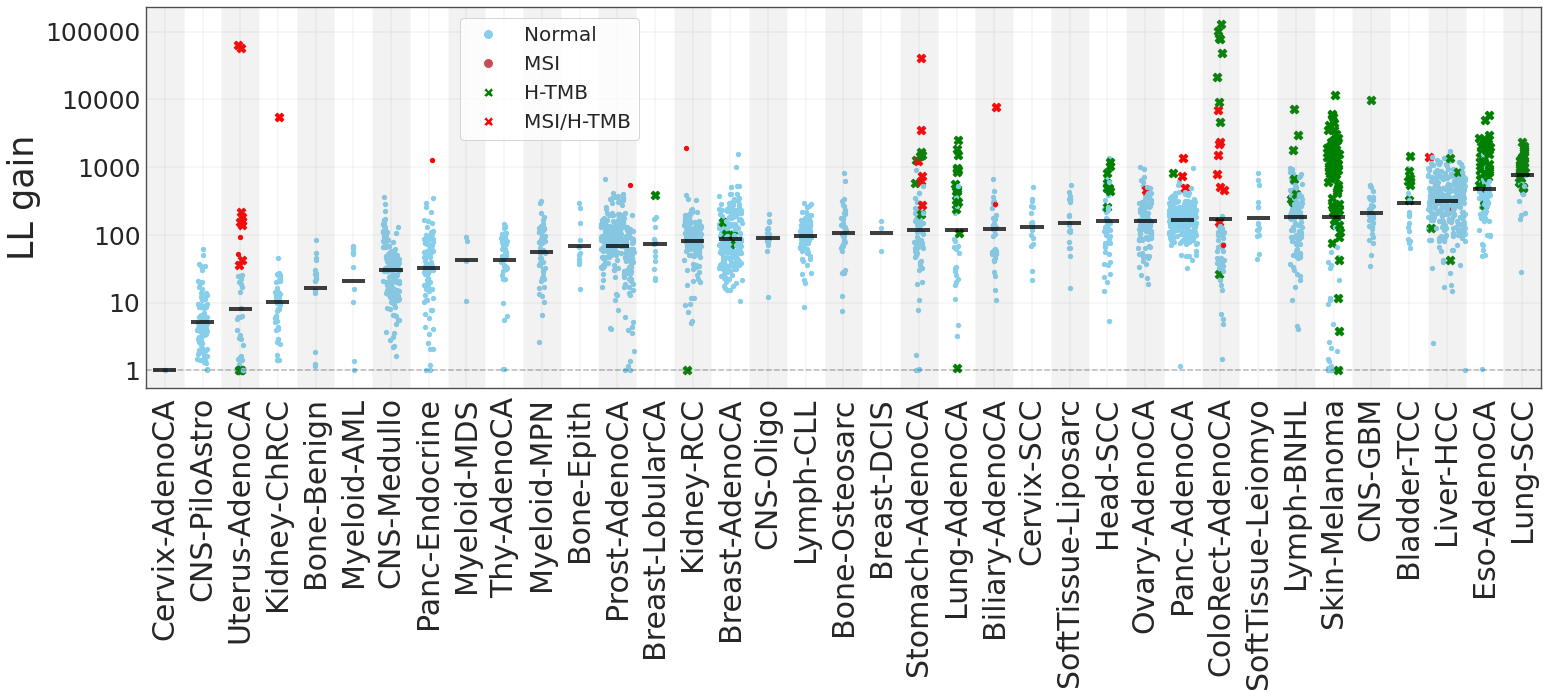

In [21]:
# Gathering of data for LL-gain plots
labels = pcawg_labels
counts = pcawg_counts
activities = sp_activities
signatures = sp_signatures
fit = np.dot(activities, signatures)
path = "./cancer_mp_inference/"
rdf = pd.read_csv(path + "r_all.csv", delimiter=",").set_index("0")

thresh = 30000

# For equal spacing in LL-gain plot
# (326 is the largest number of cancer samples of one type, i.e. Liver-HCC)
max_samples = 326
# max_samples = 484
ll_diffs = np.zeros((len(unique(labels)), max_samples))
ll_means = np.zeros(len(unique(labels)))
c_activities = np.zeros((len(unique(labels)), max_samples))

sum_means = np.zeros(len(unique(labels)))
sums = np.zeros((len(unique(labels)), max_samples))
totals = np.zeros((len(unique(labels)), max_samples))
add_muts = np.zeros((len(unique(labels)), max_samples))
sample_labels = np.zeros((len(unique(labels)), max_samples))

rem_muts = np.zeros((len(unique(labels)), max_samples))
mean_impact = np.zeros((len(unique(labels)), 96))
i = 0
for ctype in sorted(unique(labels)):
    print(i, ctype)
    ctype_ll = pd.read_csv(path + ctype + "_ll_change.csv", sep=",")
    ctype_r = rdf.loc[ctype].to_numpy()
    ctype_c = pd.read_csv(path + ctype + "_c.csv", sep=",").iloc[:, 1].to_numpy()
    ctype_idx = np.where(labels == ctype)[0]
    ctype_counts = counts[ctype_idx]
    ctype_fit = fit[ctype_idx]
    ctype_rep = (ctype_fit*(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1))).astype(int)

    temp_sums = np.full(max_samples, np.nan)
    temp_totals = np.full(max_samples, np.nan)
    temp_activities = np.full(max_samples, np.nan)
    temp_sample_labels = np.full(max_samples, np.nan)

    temp_mut_add = np.full(max_samples, np.nan)
    temp_mut_rem = np.full(max_samples, np.nan)
    mut_diff = ctype_rep - ctype_fit

    sample_mut_added = np.zeros(len(mut_diff))
    sample_mut_removed = np.zeros(len(mut_diff))

    for k in range(len(mut_diff)):
        sample = mut_diff[k]
        sample_mut_added[k] = np.sum(sample[sample > 0])
        sample_mut_removed[k] = np.sum(sample[sample < 0])

    boundary = int((max_samples - len(ctype_ll))/2)

    temp_activities[boundary:boundary + len(ctype_ll)] = ctype_c
    c_activities[i] = temp_activities
    
    temp_sample_labels[boundary:boundary + len(ctype_ll)] = np.where(labels == ctype)[0]

    temp_mut_add[boundary:boundary + len(ctype_ll)] = sample_mut_added
    temp_mut_rem[boundary:boundary + len(ctype_ll)] = sample_mut_removed
    add_muts[i] = temp_mut_add
    rem_muts[i] = temp_mut_rem

    mean_impact[i] = np.mean(1 + ctype_c.reshape(-1, 1)*ctype_r.reshape(1, -1), axis=0)

    temp_sums[boundary:boundary + len(ctype_ll)] = np.sum(np.abs(mut_diff), axis=1)
    temp_totals[boundary:boundary + len(ctype_ll)] = np.sum(ctype_counts, axis=1)
    ll_diff = np.abs(ctype_ll["After"].abs() - ctype_ll["Before"].abs())
    temp = np.full(max_samples, np.nan)
    temp[boundary:boundary + len(ctype_ll)] = ll_diff
    ll_diffs[i] = temp
    ll_means[i] = np.mean(np.log10(ll_diff + 1))
    sum_means[i] = np.mean(np.sum(np.abs(mut_diff), axis=1))
    sums[i] = temp_sums
    totals[i] = temp_totals
    sample_labels[i] = temp_sample_labels
    i += 1

plt.figure(figsize=(25, 7))
idx = np.array(range(len(unique(labels))))
idx = np.array([x for _, x in sorted(zip(ll_means, idx))])
prev = 0
c = 0
ll_gain_per_sample = []
total_ll_gain = []
ll_gain_per_corrected = []
ll_gain_per_total = []

msi_label_idx = []
for i in range(len(msi_samples)):
    msi_label_idx.append(np.where(pcawg_full_labels == msi_samples[i])[0])
msi_label_idx = np.array(msi_label_idx).reshape(1, -1)[0]

for i in idx:
    print(i)
    # y = sorted(np.log10(np.abs(ll_diffs[i]) + 1))
    y = np.log10(np.abs(ll_diffs[i]) + 1)
    htmb_idx = np.where(np.array(totals[i]) >= thresh)[0]
    
    msi_idx = []
    for j in range(len(msi_samples)):
        msi_idx2 = np.where(sample_labels[i] == msi_label_idx[j])[0]
        if msi_idx2.size > 0:
            msi_idx.append(msi_idx2[0])
    
    
    temp = ll_diffs[i][~np.isnan(ll_diffs[i])]
    ll_gain_per_sample.append(int(np.sum(np.abs(temp))/len(temp)))
    ll_gain_per_corrected.append(int(np.sum(np.abs(temp))/(np.abs(add_muts[~np.isnan(add_muts)][i]) +
                                 np.abs(rem_muts[~np.isnan(rem_muts)][i]))))
    total_ll_gain.append(int(np.sum(np.abs(temp))))
    ll_gain_per_total.append(np.sum(temp/totals[~np.isnan(totals)][i]))
    
    col = np.array(["skyblue"]*max_samples, dtype="<U9")
    mark = np.array(["."]*max_samples)
    sizes = np.array([75]*max_samples)
    col[htmb_idx] = "green"
    sizes[htmb_idx] = 75
    
    col[msi_idx] = "red"
    mark[htmb_idx] = "X"
    sizes[htmb_idx] = 75
    
    mc = 0
    for mi in range(prev, prev + max_samples):
        plt.scatter(mi, y[mc], marker=mark[mc], c=col[mc], s=sizes[mc])
        mc += 1
    
    if c % 2 == 0:
        plt.axvspan(prev, prev + max_samples, facecolor='grey', alpha=0.1)
    plt.hlines(ll_means[i],
               prev + int(max_samples/2) - 100, prev + int(max_samples/2) + 100,
               color="black", alpha=0.75, linewidth=4)
    prev += max_samples
    c += 1

plt.xticks(range(int(max_samples/2), max_samples*len(unique(labels)), max_samples),
           np.array(sorted(unique(labels)))[idx], rotation=90, fontsize=30)
# plt.gca().set_yticklabels()
# plt.yticks(ticks=1 + plt.yticks()[0], labels=[str(10**x) for x in range(int(plt.ylim()[1]) + 1)], fontsize=25)
plt.yticks(range(6), ["1", "10", "100", "1000", "10000", "100000"], fontsize=25)

plt.hlines(0, 0, max_samples*len(unique(labels)), color="black", linestyle="--", alpha=0.25)
plt.ylabel("LL gain", fontsize=35)
# plt.title("Per-sample log-likelihood gain", fontsize=30)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='skyblue', ms=10, linewidth=0),
                   Line2D([0], [0], marker='o', color='w', label='MSI', markerfacecolor='r', ms=10, linewidth=0),
                   Line2D([0], [0], marker='X', color='w', label='H-TMB', markerfacecolor='green', ms=10, linewidth=0),
                   Line2D([0], [0], marker='X', color='w', label='MSI/H-TMB', markerfacecolor='red', ms=10, linewidth=0)]

plt.legend(handles=legend_elements, loc=(0.225, 0.65), fontsize=20)
plt.margins(x=0)
plt.show()